In [79]:
import copy
import random
import time
import math

from helpers import get_best_point
from test_functions import Function
import copy
from point_hrtf import Point

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sp
import numpy as np
import pandas as pd

import sys
from scipy.signal import freqz
import scipy.io

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Class Population

In [9]:
class Population:
    def __init__(self, dim=2, num_points=50, upper_limit=10, lower_limit=-10, init_generate=True, objective=None):
        self.points = []
        self.num_points = num_points
        self.init_generate = init_generate
        self.dim = dim
        self.range_upper_limit = upper_limit
        self.range_lower_limit = lower_limit
        self.objective = objective
        # If initial generation parameter is true, then generate collection
        if self.init_generate == True:
            for ix in range(num_points):
                new_point = Point(dim=dim, upper_limit=self.range_upper_limit,
                                  lower_limit=self.range_lower_limit, objective=self.objective)
                new_point.generate_random_point()
                self.points.append(new_point)
         
        
        
    def get_visualization(self, leaders=None, plot_leaders=False):
        # Displays 2D animation of points converging to minima
        pts = self.points
        plt.ion()
        plt.clf()
        plt.xlim(self.range_lower_limit, self.range_upper_limit)
        plt.ylim(self.range_lower_limit, self.range_upper_limit)

        for px in pts:
            plt.scatter(px.coords[0], px.coords[1])

        if plot_leaders == True and leaders is not None:
            for lx in leaders:
                plt.scatter(lx.coords[0], lx.coords[1], c='r')
        plt.pause(0.05)
    
    def remove(self,l):
        c=0
        cord_list = [x.coords.tolist() for x in l]
        for i, o in enumerate(self.points):
            if o.coords.tolist() in cord_list:
                del self.points[i]
                c=c+1
        self.num_points = self.num_points - c
    
    def prepare(self,l):
        self.num_points = len(l)
        self.points = []
        for ix in range(self.num_points):
            #pt = l[ix]
            new_point = Point(dim=self.dim, upper_limit=self.range_upper_limit,
                                  lower_limit=self.range_lower_limit, objective=self.objective)
            new_point.generate_definite_point(z1 = l[ix])
            self.points.append(new_point)
    
    
    def get_average_objective(self):
        avg = 0.0
        for px in self.points:
            px.evaluate_point()
            avg += px.z
        avg = avg/float(self.num_points)
        return avg

# Class Cluster_jDE clustering based differential evolution

In [27]:
def calc_dist(pt1,pt2):
    return (np.square(np.sum((np.array(pt1.coords) - np.array(pt2.coords)))))**0.5

class Cluster_DE():
    def __init__(self, num_iterations=10, CR=0.4, F=0.48, dim=2, population_size=10, print_status=False, visualize=False,M=5,tau1=0.1,tau2=0.1, func=None):
        #random.seed(10)
        self.print_status = print_status
        self.visualize = visualize
        self.num_iterations = num_iterations
        self.iteration = 0
        self.CR = CR
        self.F = F
        self.population_size = population_size
        self.func = Function(func=func)
        self.population = Population(dim=dim, num_points=self.population_size, objective=self.func)
        self.cluster = []
        self.M = M
        self.sol = []
        self.C = []
        self.tau1 = tau1
        self.tau2 = tau2
        
    def plot_contour_sol(self,solutions):
        def Rastrigin(*X, **kwargs):
            A = kwargs.get('A', 10)
            return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])
        #--------Rastrigin func---------
        X = np.linspace(-4, 4, 200)    
        Y = np.linspace(-4, 4, 200)    
        X, Y = np.meshgrid(X, Y)
        Z = Rastrigin(X, Y, A=10)
        print(" last gen contour_plot ")
        fig = plt.figure(figsize=(8,6))
        plt.contour(X,Y,Z)
        plt.scatter(solutions[-1][0], solutions[-1][1],s=100, marker='+')
        plt.show()
        
    def iterate(self):
        for ix in range(self.population.num_points):
            x = self.population.points[ix]
            [a, b, c] = random.sample(self.population.points, 3)
            while x == a or x == b or x == c:
                [a, b, c] = random.sample(self.population.points, 3)

            R = random.random() * x.dim
            y = copy.deepcopy(x)

            for iy in range(x.dim):
                ri = random.random()

                if ri < self.CR or iy == R:
                    y.coords[iy] = a.coords[iy] + self.F * (b.coords[iy] - c.coords[iy])

            y.evaluate_point()
            if y.z < x.z:
                self.population.points[ix] = y
    
    def func_cluster(self):
        self.sol = []
        self.C=[]
        C = []
        
        for j in range(0,int(self.population.num_points/self.M)):
            dist=[]
            pnt = get_best_point(self.population.points)
            self.sol.append(pnt)
            for pt in self.population.points:
                p_dist = calc_dist(pt,pnt)
                dist.append([pt,p_dist])
                dist.sort(key = lambda i: i[1])
            if len(dist)>self.M:
                for i in range(0,self.M):
                    pt = dist[i][0]
                    self.C.append(pt.coords)
                    C.append(pt)
            else:
                for i in range(0,len(dist)):
                    pt = dist[i][0]
                    self.C.append(pt.coords)
                    C.append(pt)
            self.population.remove(C)
            self.jDE()
        
        self.iteration += 1
        
    def jDE(self):
        F_old = self.F
        CR_old = self.CR
        #IF  = random.random() < self.tau1;
        #ICR = random.random() < self.tau2;
        F_new  = (0.1 + 0.9 * random.random()) if random.random() < self.tau1 else self.F
        CR_new = (0.0 + 1.0 * random.random()) if random.random() < self.tau2 else self.CR
        if (F_old == F_new) or (CR_old == CR_new):
            self.iterate()
        else:
            self.iterate()
            pnt = get_best_point(self.population.points)
            self.F = F_new
            self.CR = CR_new
            self.iterate()
            pnt_1 = get_best_point(self.population.points)
            if pnt_1.z >= pnt.z:
                self.F = F_old
                self.CR = CR_old
                self.iterate()
        
    
    def simulate(self,plot=True):
        all_vals = []
        avg_vals = []
        solutions=[]
        #pts = []
        sol_df = pd.DataFrame(columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30',
                                       'x31','x32','x33','x34','x35','x36','x37','x38','x39','x40','x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','cluster','gen','opp'])
        pnt = get_best_point(self.population.points)
        all_vals.append(pnt.z)
        avg_vals.append(self.population.get_average_objective())
        print("Initial best value: " + str(pnt.z))
        if plot == True:
            print("Initial pop: ")
            self.population.get_visualization(plot_leaders=True)
        
        while self.iteration < self.num_iterations:
            self.func_cluster()
            solu = []
            opp = []
            for pt in self.sol:
                solu.append(pt.coords.tolist())
                opp.append(pt.z)
            sol_temp = pd.DataFrame(solu,columns=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30',
                                       'x31','x32','x33','x34','x35','x36','x37','x38','x39','x40','x41','x42','x43','x44','x45','x46','x47','x48','x49','x50'])
            sol_temp['cluster'] = [i for i in range(0,len(solu))]
            sol_temp['gen'] = [self.iteration for i in sol_temp.x1]
            sol_temp['opp']=np.array(opp)
            sol_df = sol_df.append(sol_temp)
            self.population.prepare(self.C)
            if self.print_status == True and self.iteration%100 == 0:
                pnt = get_best_point(self.population.points)
                print(pnt.z, self.population.get_average_objective())
            best = get_best_point(self.population.points)
            solutions.append(best.coords)
            #pts.append(best)
            all_vals.append(best.z)
            avg_vals.append(self.population.get_average_objective())
            
        # sns.figure(0)
        if plot == True:
            print('end pop:')
            self.population.get_visualization(plot_leaders=True)
        
            self.plot_contour_sol(solutions)
        
            plt.plot(all_vals, 'r', label='Best')
            plt.plot(avg_vals, 'g', label='Average')
            plt.legend()
            plt.xlabel('Iterations')
            plt.ylabel('Objective Function Value')
            plt.title(self.func.func_name + ', ' + str(self.population.dim) + '-D')
            plt.show()
        pnt = get_best_point(self.population.points)
        print("Final best value: " + str(pnt.z))
        
        return sol_df,pnt.z 

In [ ]:
de = Cluster_DE(num_iterations=50, dim=24, CR=0.4, F=0.48, population_size=512, print_status=True,M=20, func='rastrigin')
de.jDE()

# Algo working

c:\users\nkumb\anaconda3\envs\covid\lib\site-packages\scipy\signal\filter_design.py:470: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))


Initial best value: 9.499883173409037
Initial pop: 


c:\users\nkumb\anaconda3\envs\covid\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


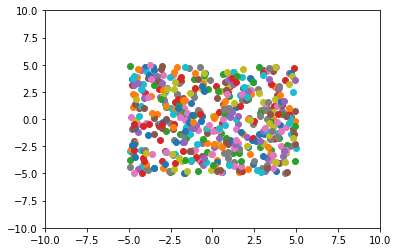

6.350620688070366 87.12753528369527
6.350620688070366 93.53029905769468
6.350620688070366 8.069593127984438
6.350620688070366 6.858001866263853
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.400204409144408
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.365383044457285
6.350620688070366 7.36538304

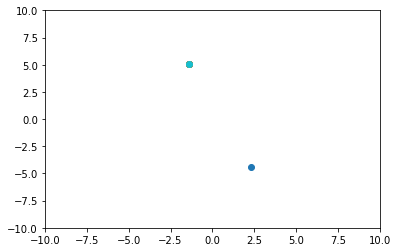

 last gen contour_plot 


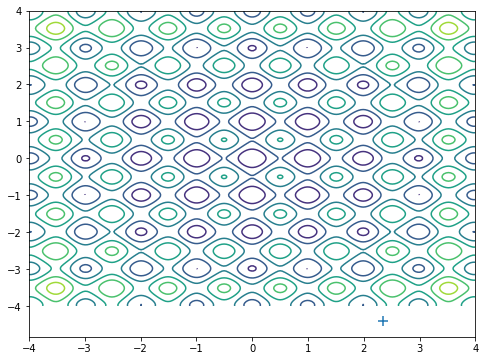

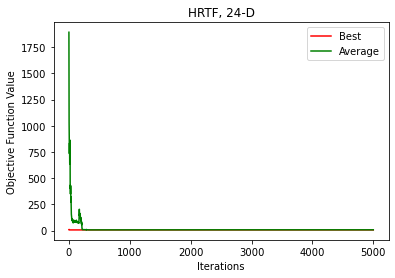

Final best value: 6.350620688070366


In [32]:
de = Cluster_DE(num_iterations=5000, dim=24, CR=0.4, F=0.48, population_size=512, print_status=True,M=30, func='HRTF')
sol_df,val = de.simulate()

In [34]:
sol_df.to_csv('solution.csv')

In [35]:
sol_df.head()

x1                        x2  \
0    (-4.45956359094696+0j)  (-0.4791657020328337+0j)   
1   (-4.264471744762673+0j)   (1.2344592844054647+0j)   
2   (-5.897710776029296+0j)    (4.812570056533614+0j)   
3  (-0.8651809351160109+0j)   (-3.554966615379169+0j)   
4  (-0.9453374309122915+0j)    (4.010821793325329+0j)   

                         x3                        x4  \
0   (1.6763784220356737+0j)    (3.713814600825021+0j)   
1    (2.623202884246055+0j)   (2.0567903070017355+0j)   
2  (-0.8877228507913877+0j)  (-4.6916152100335795+0j)   
3    (0.273803424666371+0j)   (-6.286030952313355+0j)   
4    (4.617668539875643+0j)    (3.993357260442022+0j)   

                         x5                        x6  \
0  (0.48795744543880204+0j)  (-0.6049282008764756+0j)   
1   (2.4449921665129493+0j)   (-4.789841423247222+0j)   
2   (0.9369183371593208+0j)  (-3.7558834832325285+0j)   
3  (-1.3056215675447813+0j)  (0.22408740853568115+0j)   
4   (3.3136161361985073+0j)    (0.904945807235241+0j)   

                         x7                        x8  \
0    (4.222371472591998+0j)  (-1.5779126117799178+0j)   
1     (3.94594825794041+0j)   (-2.016547082918174+0j)   
2   (-0.851917970399878+0j)  (-1.8727308828125198+0j)   
3  (0.13804116845596326+0j)  (0.41125515275949187+0j)   
4   (-4.775276515930445+0j)   (-1.973096290272282+0j)   

                         x9                       x10  ...  \
0   (1.7522556103792963+0j)  (-1.0968017500515161+0j)  ...   
1     (4.17564982331716+0j)   (0.7174752633569401+0j)  ...   
2     (3.16297419598369+0j)   (-2.343813451030822+0j)  ...   
3  (-3.9683117439006024+0j)   (2.5506695331938634+0j)  ...   
4    (1.916309413968795+0j)  (-0.9595957200221439+0j)  ...   

                                              x44  \
0   (0.08531804023829724-2.3314683517128287e-15j)   
1   (0.26081085779756075-1.2628786905111156e-15j)   
2     (0.1095140961950394-6.413272690686256e-15j)   
3  (0.008547603462287664+3.8267999880048365e-15j)   
4    (0.027717744444306462-2.71657696337968e-15j)   

                                               x45  \
0  (-0.007287131324841293-1.3704315460216776e-15j)   
1   (-0.13228789430542148+3.2890357104520263e-15j)   
2    (0.004869394884785078-3.209238430557093e-15j)   
3  (-0.022028573534890974+1.6080886622305002e-15j)   
4  (-0.020691103408534754+2.0990154059319366e-16j)   

                                              x46  \
0   (-0.01142384982056847+5.898059818321144e-17j)   
1   (0.06234292141342388-7.7021722333370235e-16j)   
2    (0.05352651634520593-4.579669976578771e-16j)   
3  (0.004103202634745694-3.8337388819087437e-16j)   
4  (0.011782982650351981+2.5760643618255585e-16j)   

                                               x47  \
0    (-0.00513250504325124+6.364266752489911e-17j)   
1  (-0.025304728888288386-1.0234868508263162e-16j)   
2      (0.0121796897144115+6.938893903907228e-17j)   
3   (0.0018022018564395853-5.074066167232161e-17j)   
4  (-0.005784216456819482+1.7780915628762273e-17j)   

                                               x48  \
0    (0.01317509950887975-3.5561831257524545e-17j)   
1    (0.009170228684130578-7.806255641895632e-18j)   
2    (0.011776669218937538-6.938893903907228e-18j)   
3    (0.001450197271910926+7.318364664277155e-18j)   
4  (0.0026632763864391108-1.8214596497756474e-17j)   

                                                x49  \
0  (-0.0072171502036034035+2.2551405187698492e-17j)   
1   (-0.002675668418106279+1.1926223897340549e-17j)   
2    (0.0018193579819387633-4.336808689942018e-19j)   
3   (-0.0018271945292092872+8.348356728138384e-18j)   
4   (-0.0008513875835797833+4.336808689942018e-19j)   

                                               x50 cluster gen        opp  
0  (0.0014611021987218841-4.9873299934333204e-18j)       0   1   9.499883  
1  (0.0005826990862625778-2.0599841277224584e-18j)       1   1  15.752389  
2  (0.0008955394671466689-1.6805133673525319e-18j)       2   1  15.752389  
3   (0.0005046483997473112-2.439

In [37]:
sol_df.reset_index(inplace=True)

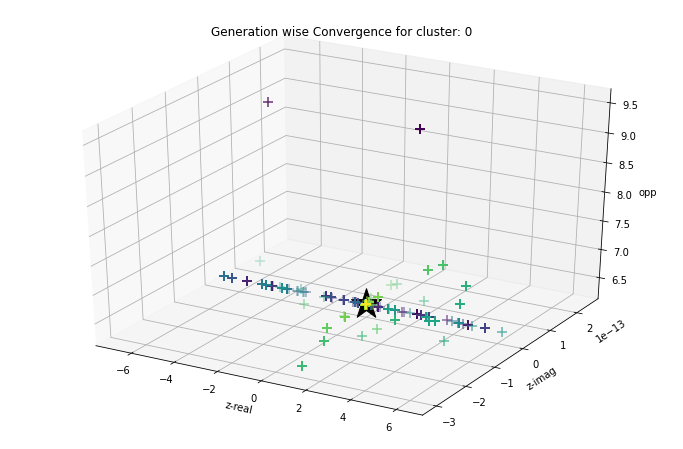

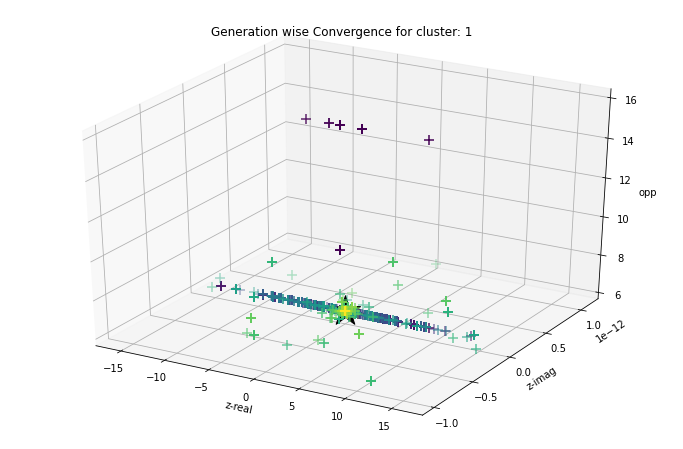

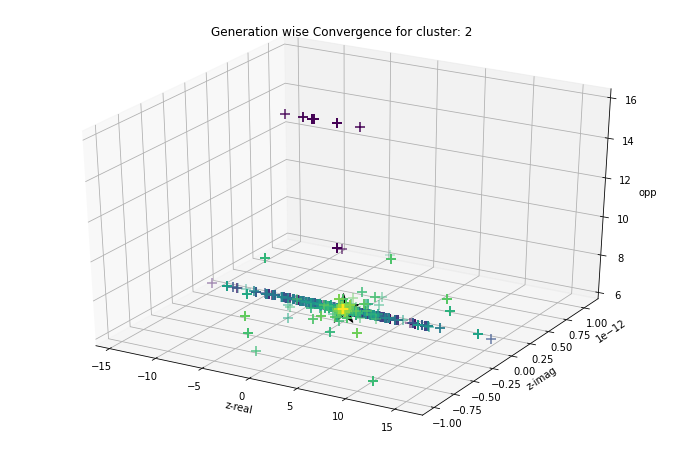

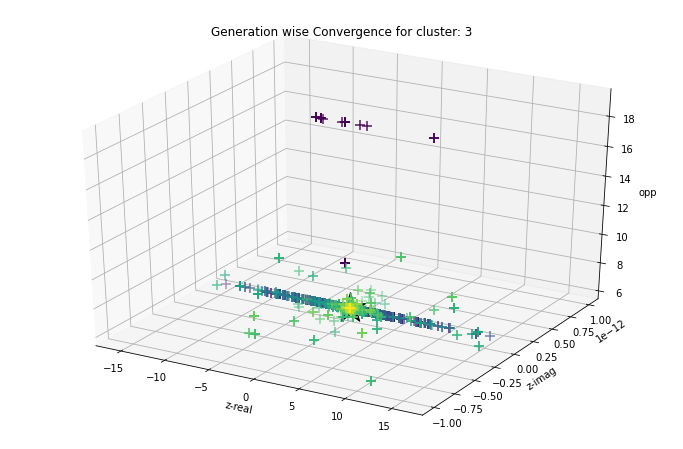

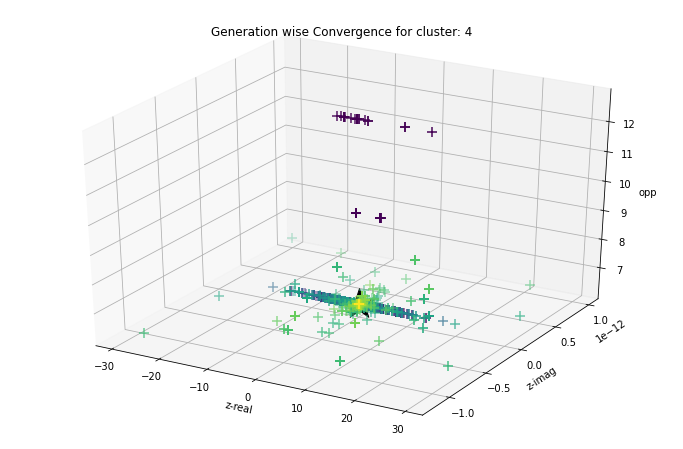

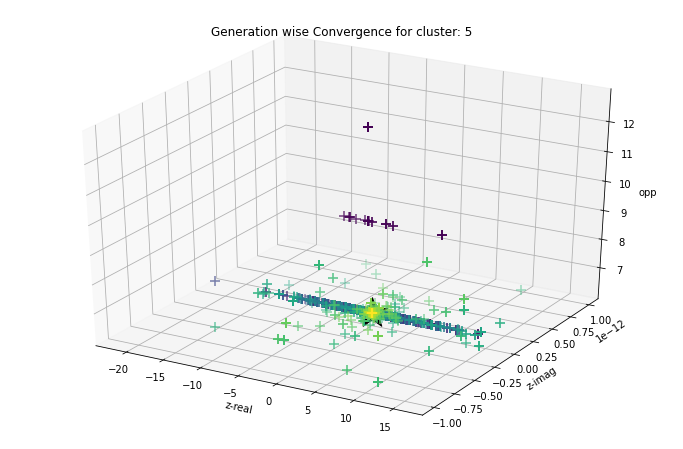

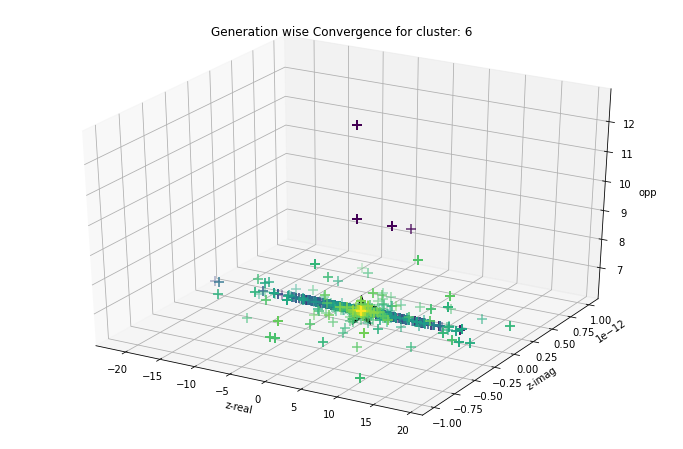

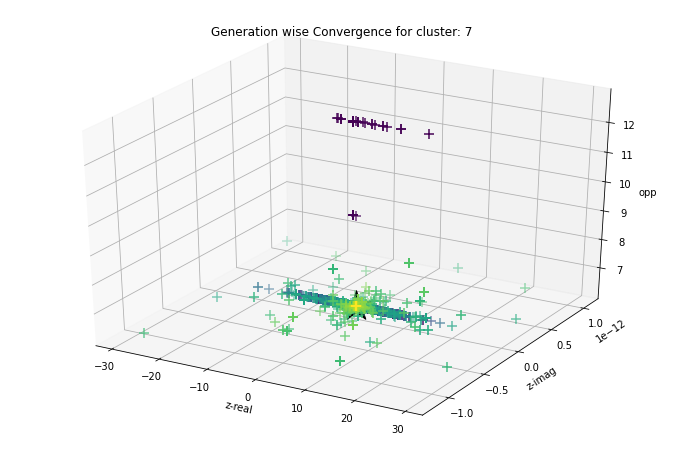

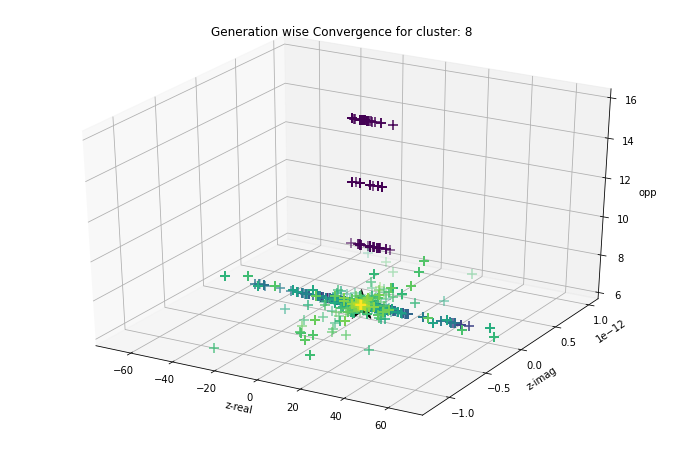

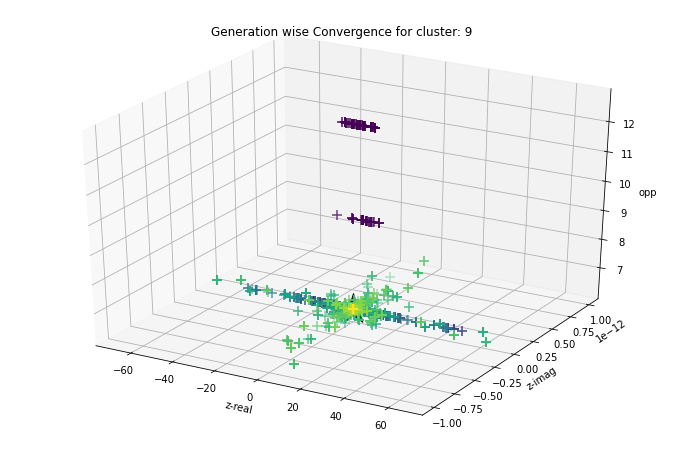

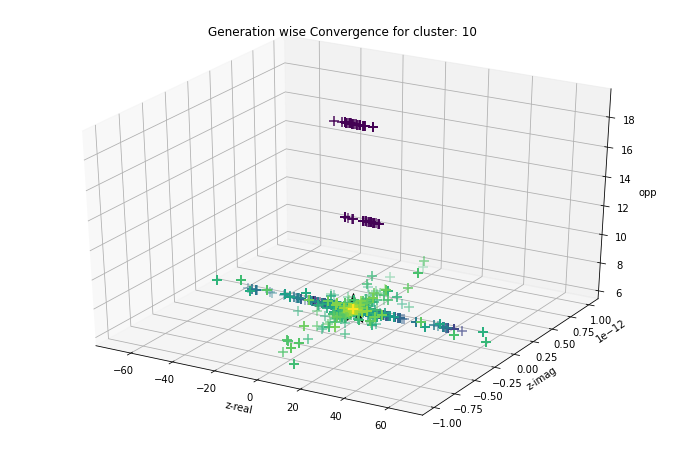

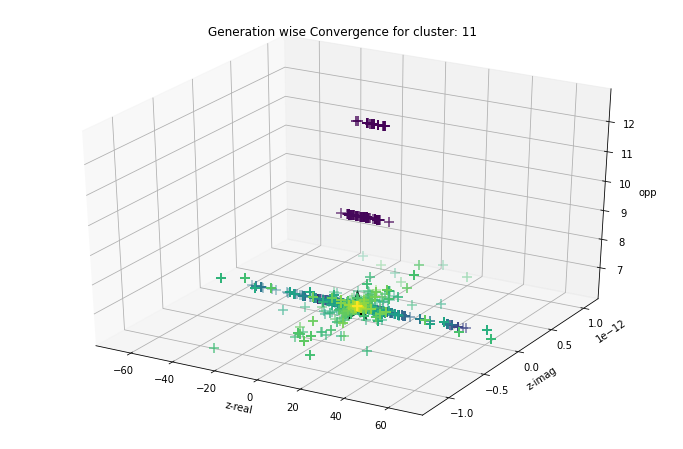

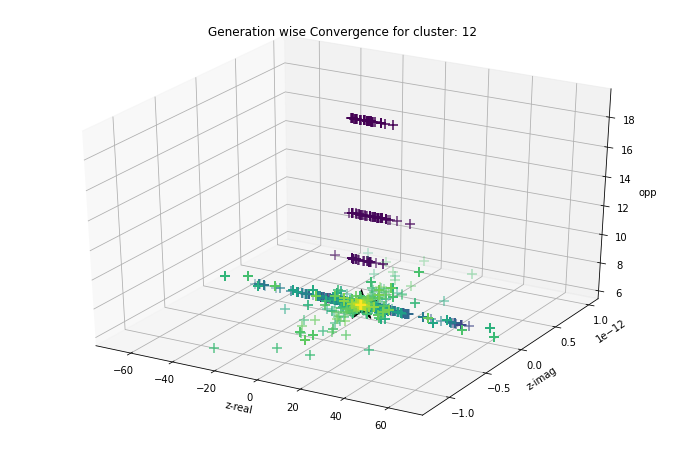

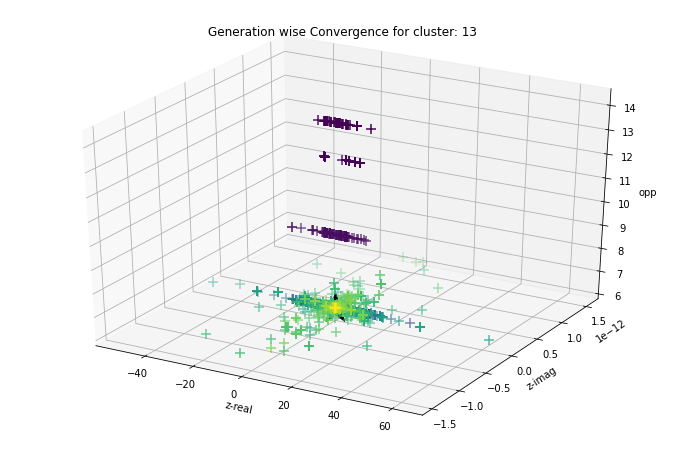

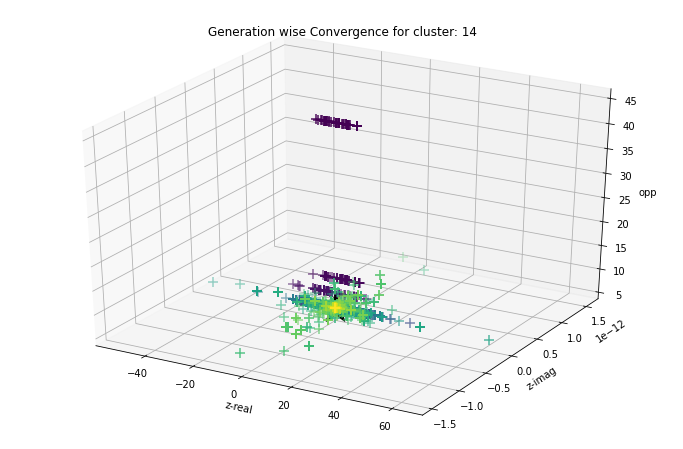

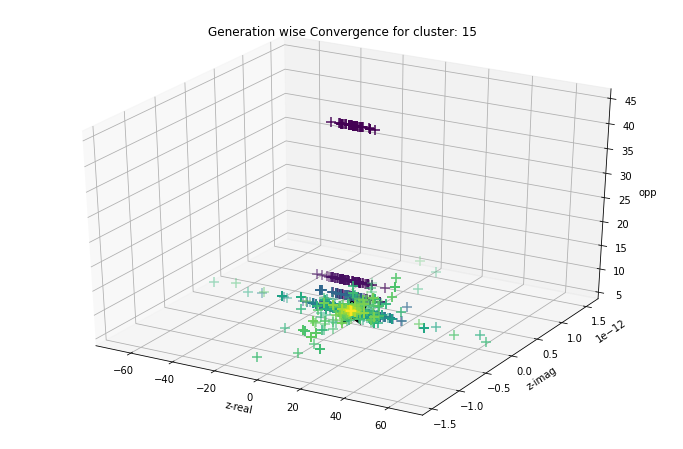

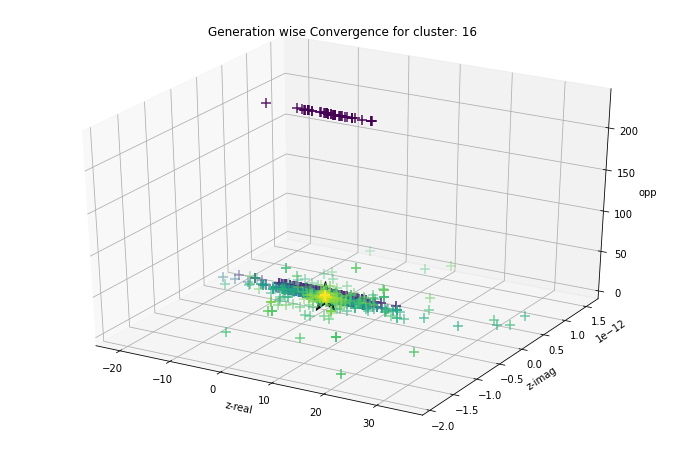

In [163]:
for cl in sol_df.cluster.unique():
    df_temp = sol_df[sol_df.cluster == cl]
    df_temp.reset_index(inplace=True)
    minimum = np.min(df_temp.opp)
    ind=df_temp[df_temp.opp == minimum].index 
    real,imag,opp,gen=[],[],[],[]
    for col in z_col:
        for x in df_temp[col]:
            real.append(x.real)
            imag.append(x.imag)
    for i in range(len(df_temp)):
        for j in range(len(z_col)):
            opp.append(df_temp['opp'][i])
            gen.append(df_temp['gen'][i])
    fig = plt.figure(figsize=(12,8))
    ax_1 = fig.gca(projection='3d')
    ax_1.scatter3D(real,imag,opp, s=100,marker='+',c=gen,zorder=1)
    ax_1.scatter3D(df_temp[col][ind[-1]].real,df_temp[col][ind[-1]].imag,minimum, s=1000,marker='*',c='black',zorder=2)
    ax_1.set_xlabel('z-real')
    ax_1.set_ylabel('z-imag')
    ax_1.set_zlabel('opp')
    plt.title('Generation wise Convergence for cluster: '+str(cl))

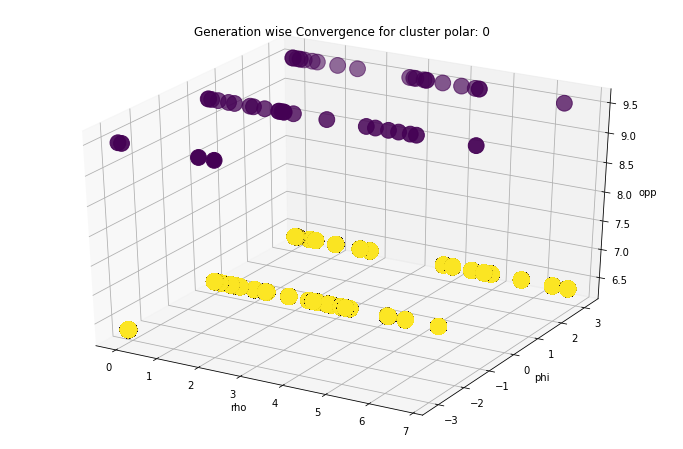

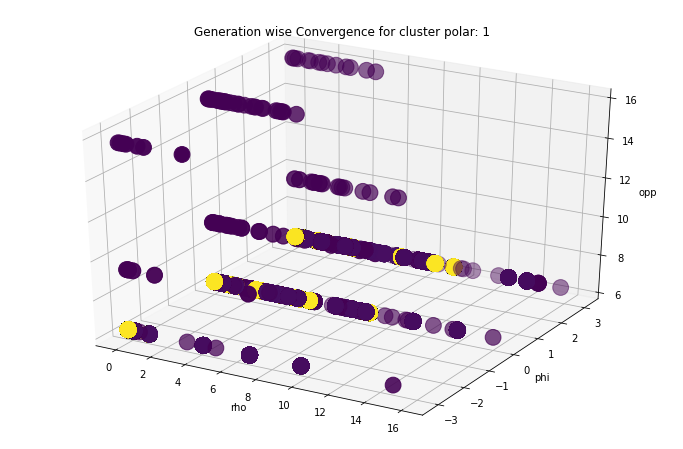

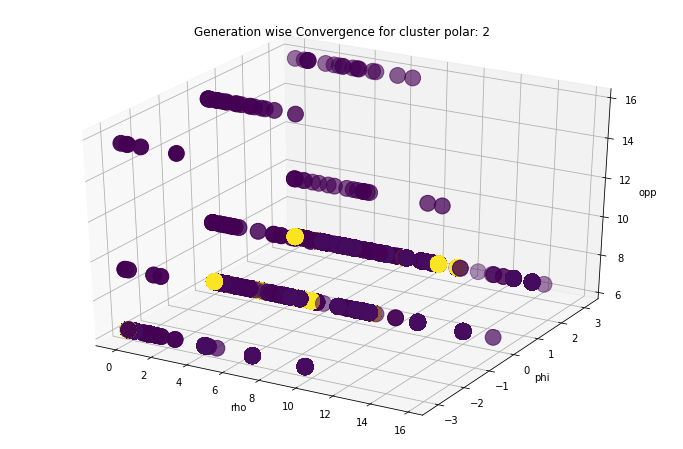

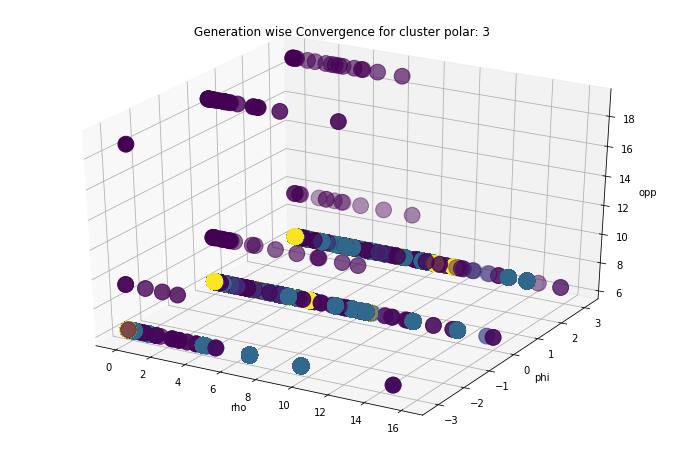

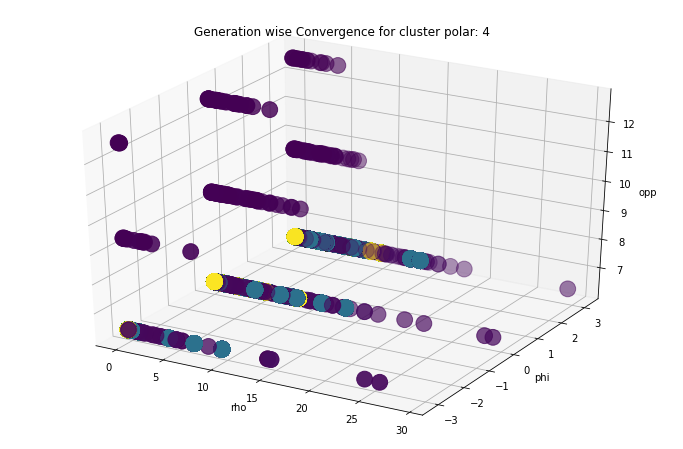

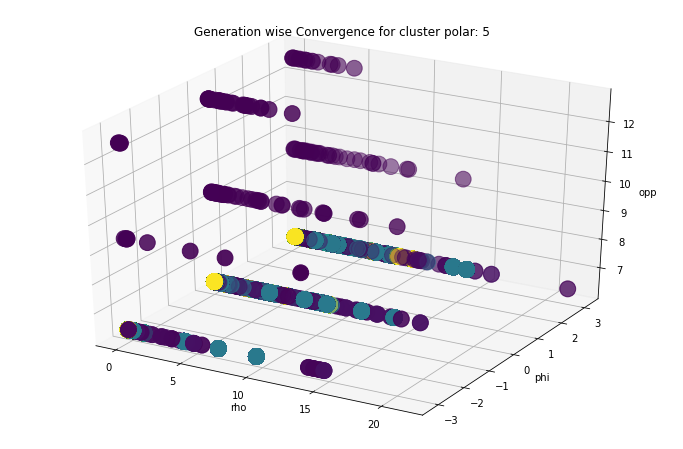

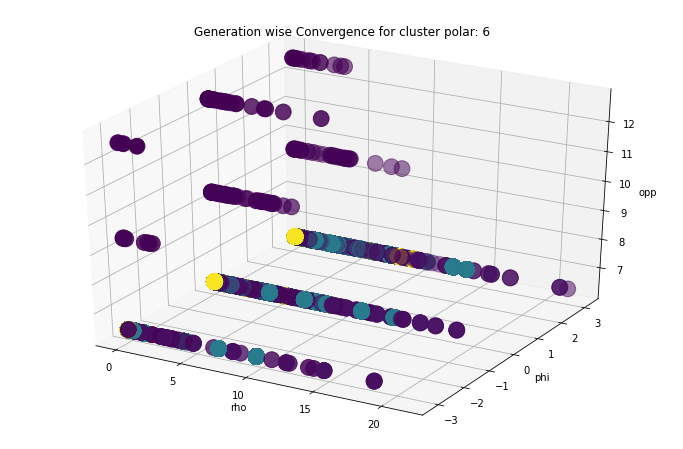

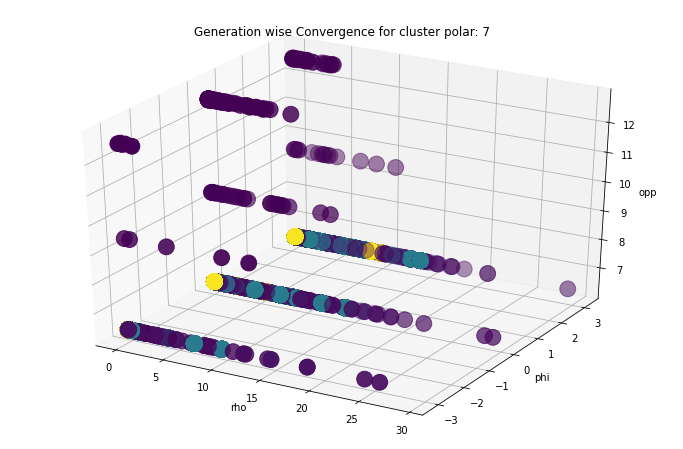

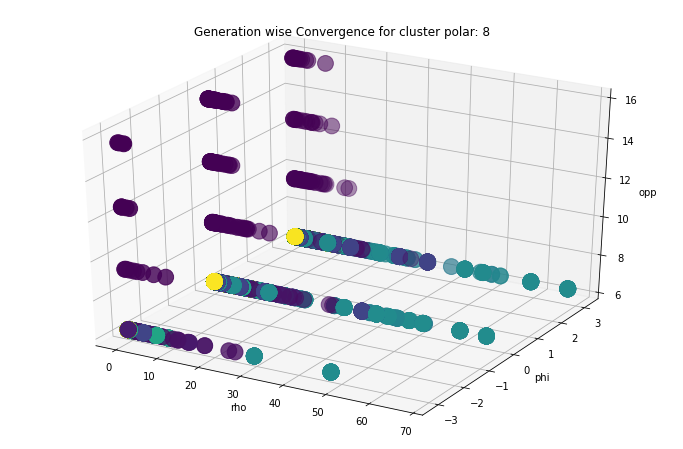

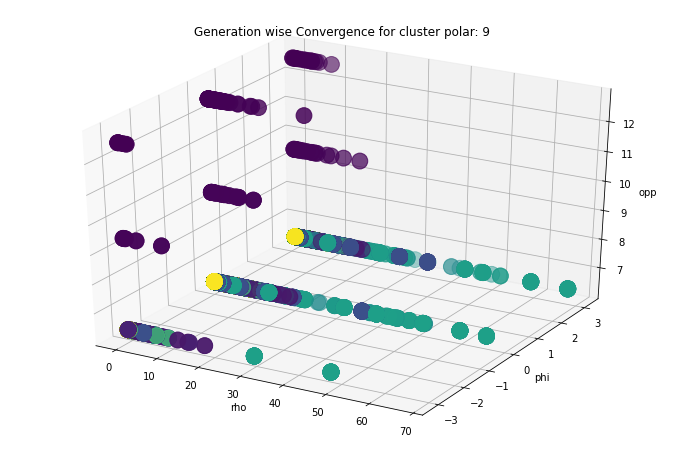

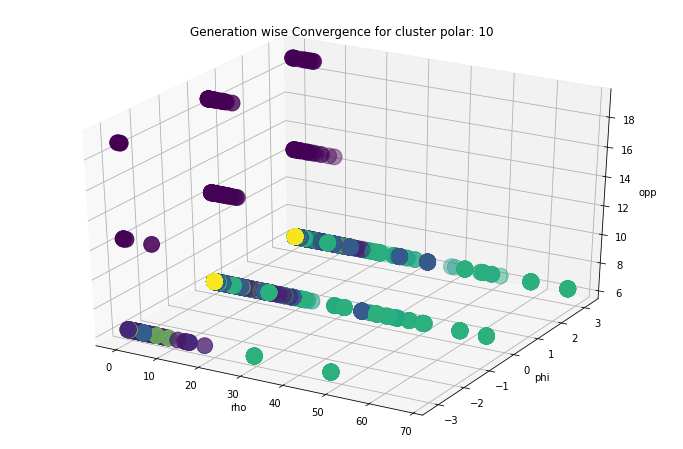

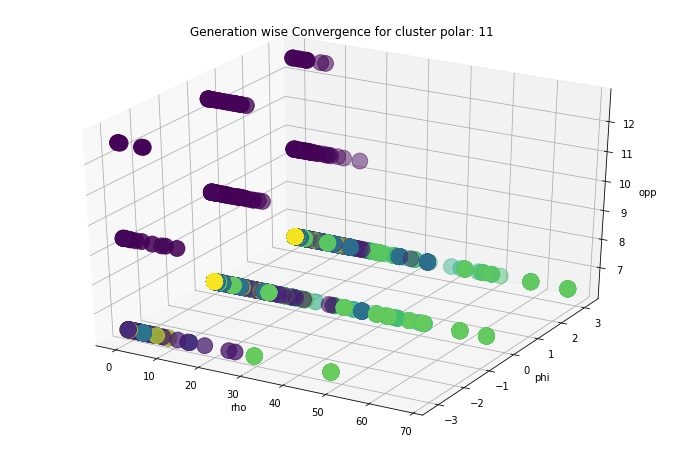

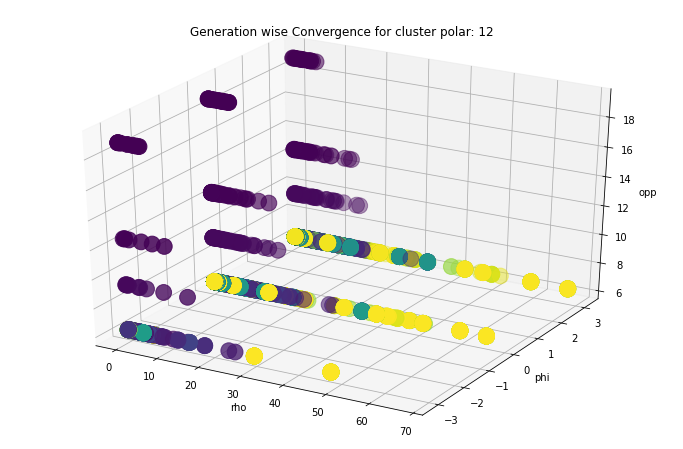

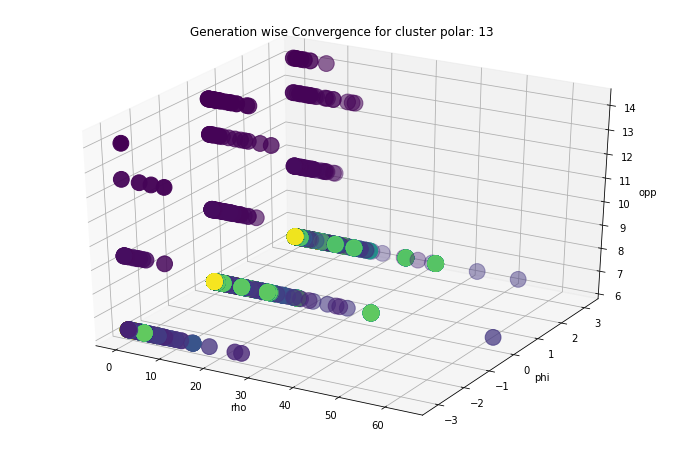

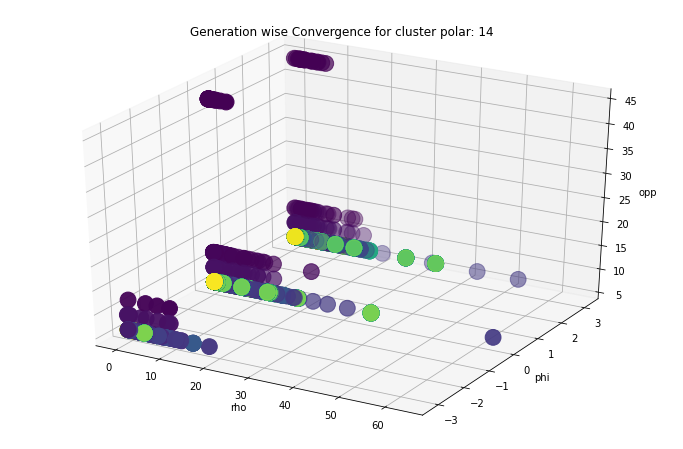

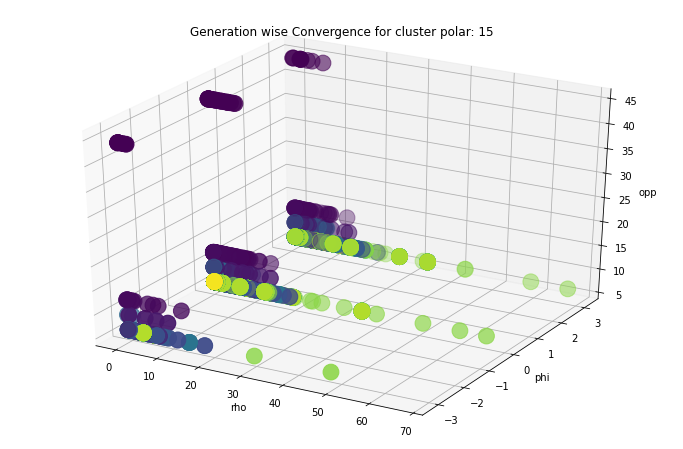

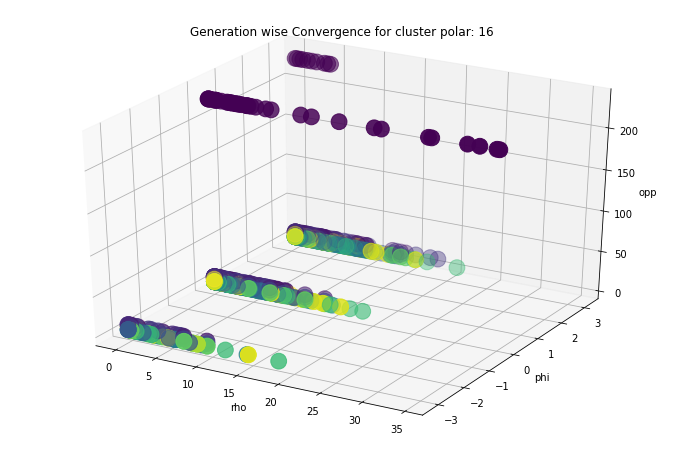

In [116]:
for cl in sol_df.cluster.unique():
    df_temp = sol_df[sol_df.cluster == cl]
    df_temp.reset_index(inplace=True)
    real,imag,opp,gen,rho,phi=[],[],[],[],[],[]
    for col in z_col:
        for x in df_temp[col]:
            real.append(x.real)
            imag.append(x.imag)
        opp.append(df_temp['opp'])
        gen.append(df_temp['gen'])
    rho,phi = cart2pol(real,imag)
    fig = plt.figure(figsize=(12,8))
    ax_1 = fig.gca(projection='3d')
    ax_1.scatter3D(rho,phi,opp, s=1000,marker='.',c=gen)
    ax_1.set_xlabel('rho')
    ax_1.set_ylabel('phi')
    ax_1.set_zlabel('opp')
    plt.title('Generation wise Convergence for cluster polar: '+str(cl))

c:\users\nkumb\anaconda3\envs\covid\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


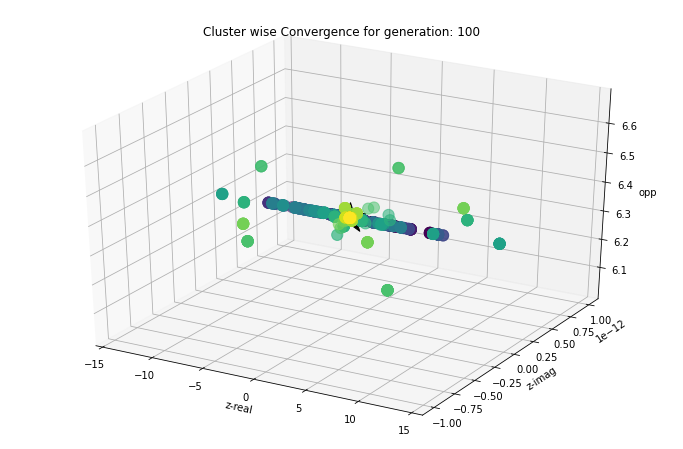

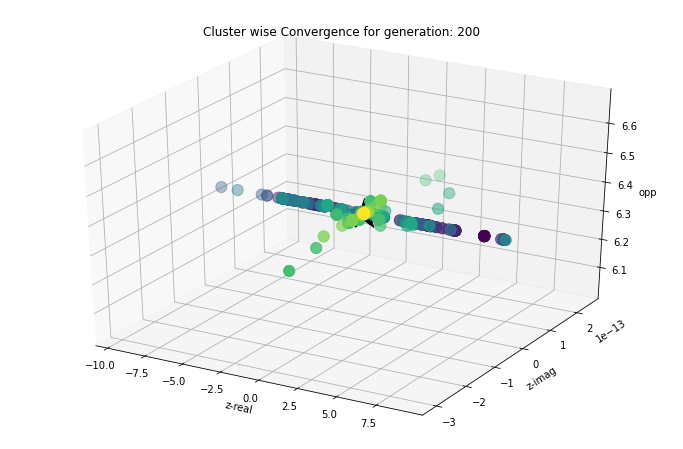

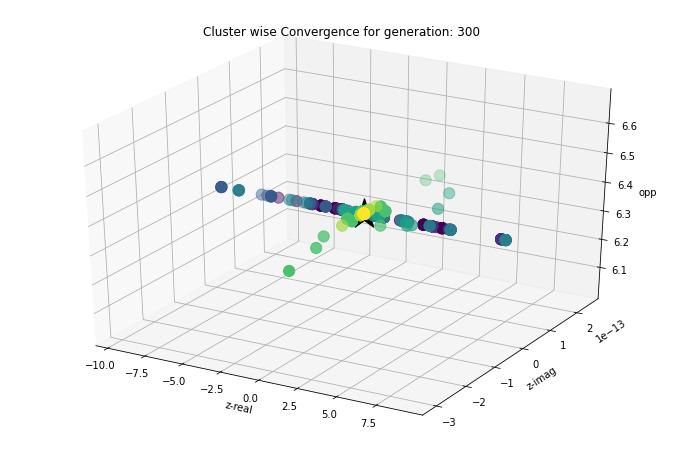

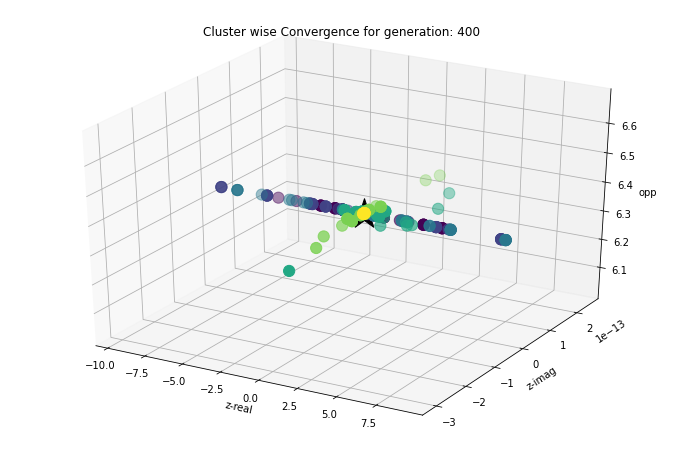

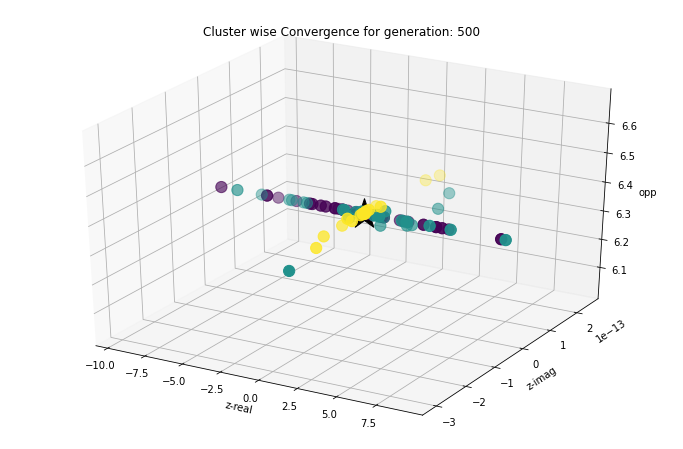

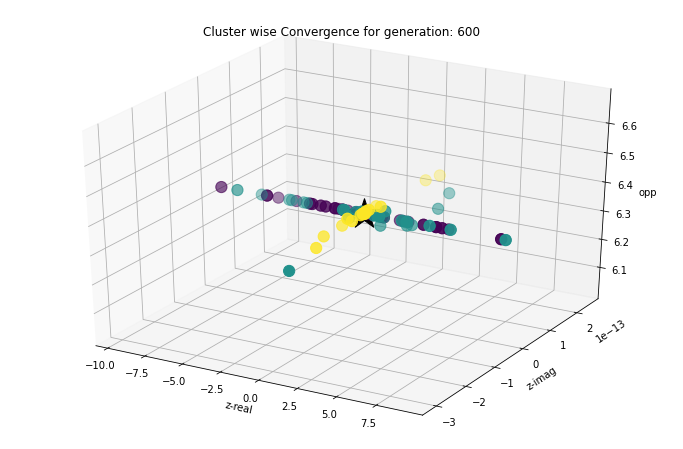

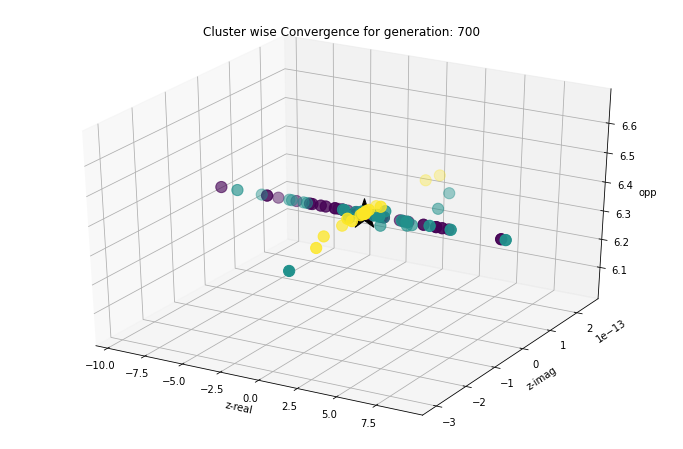

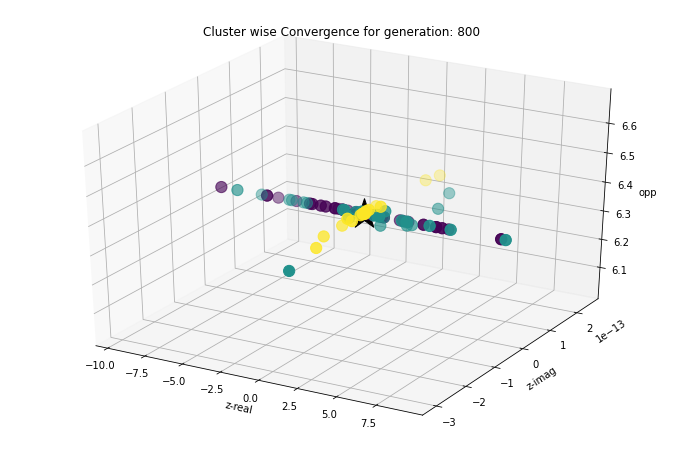

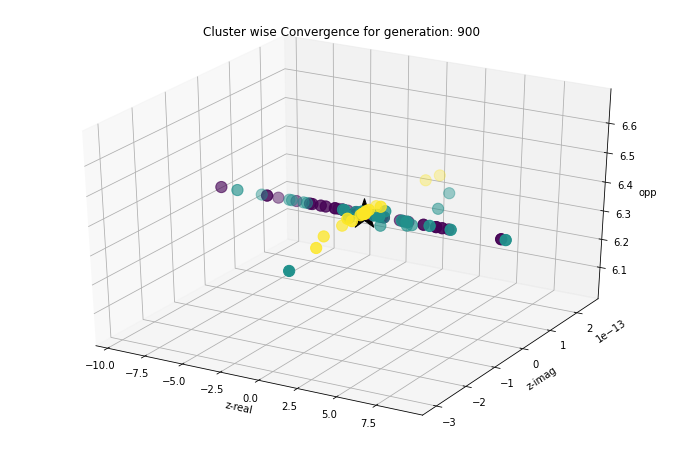

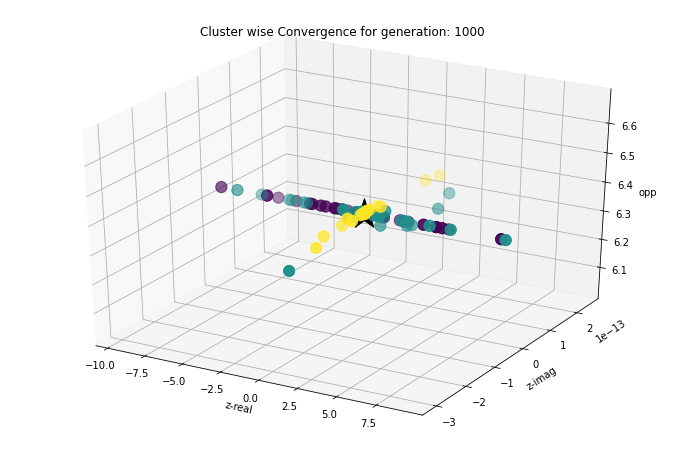

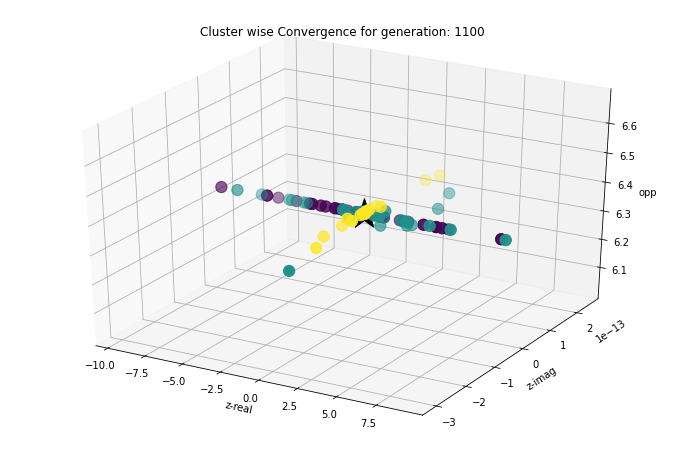

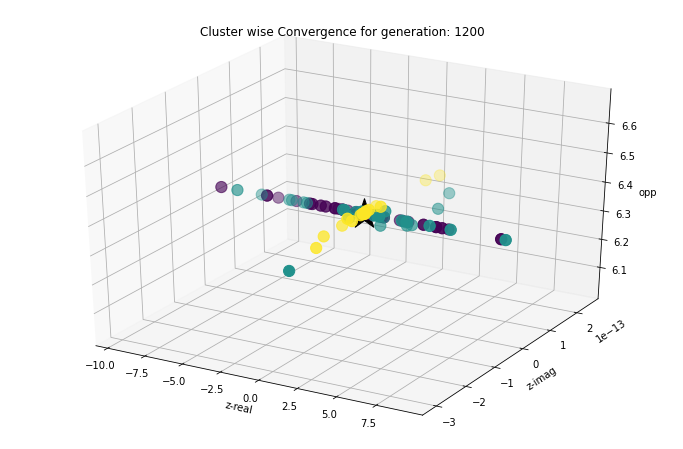

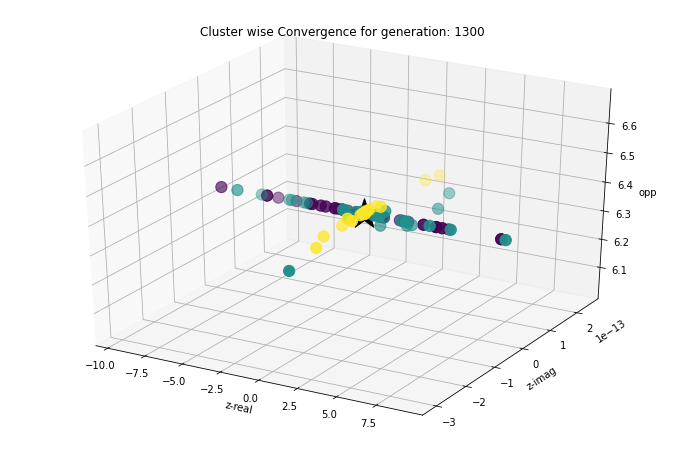

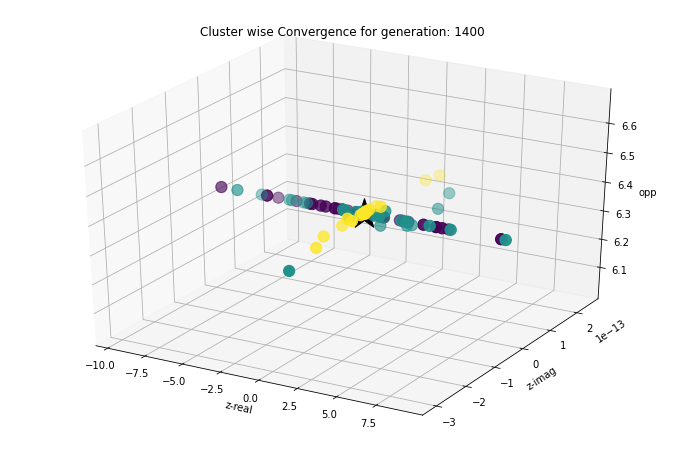

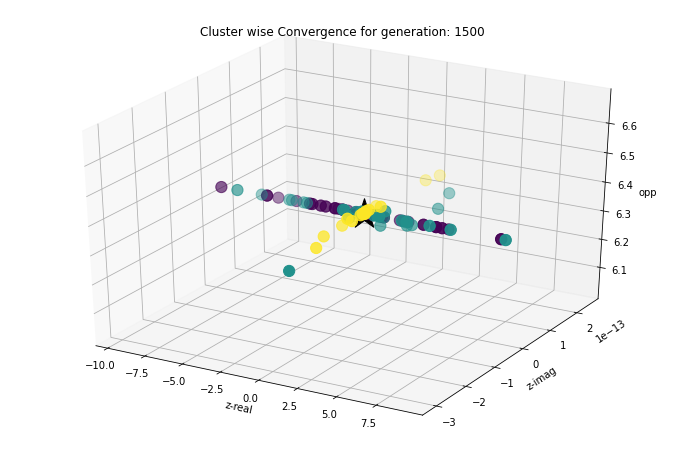

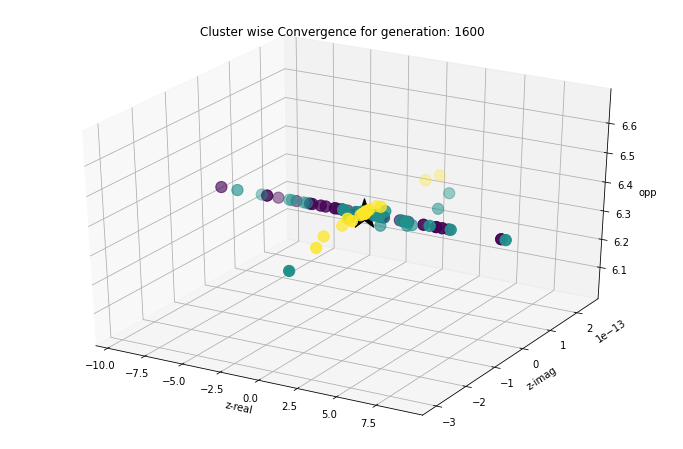

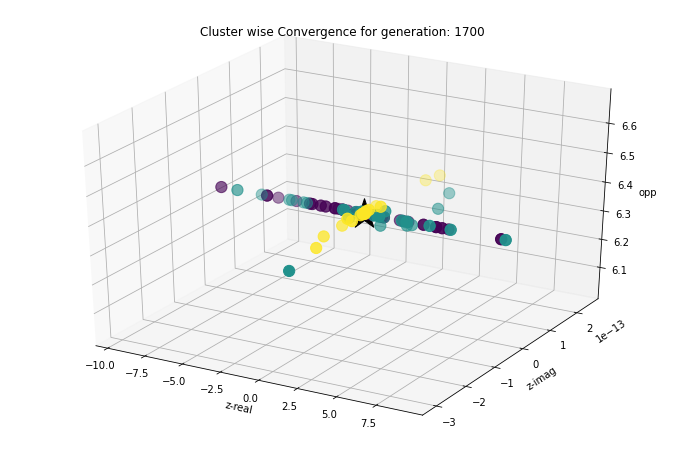

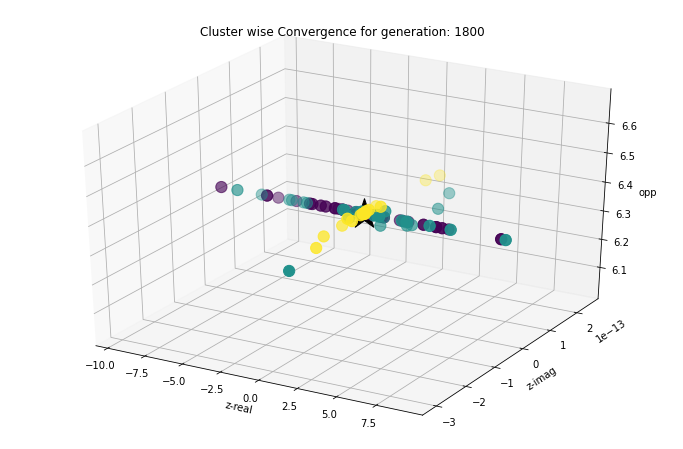

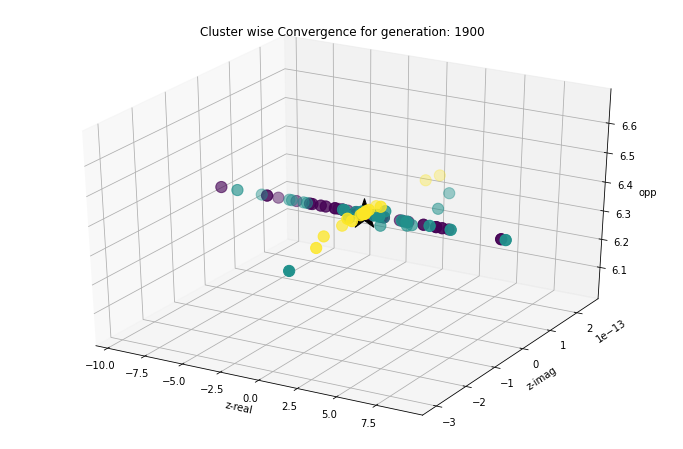

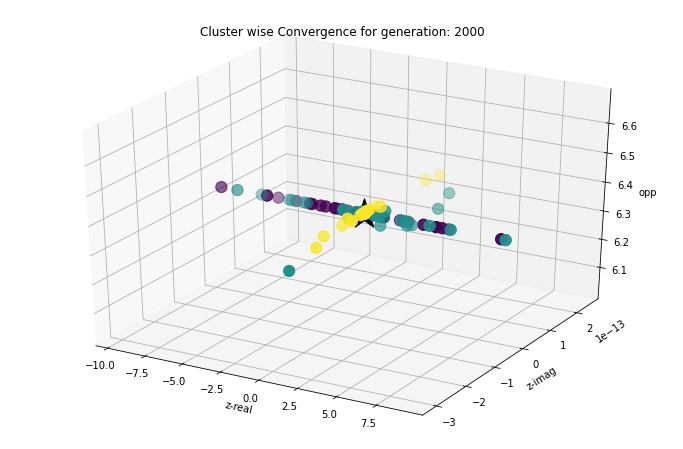

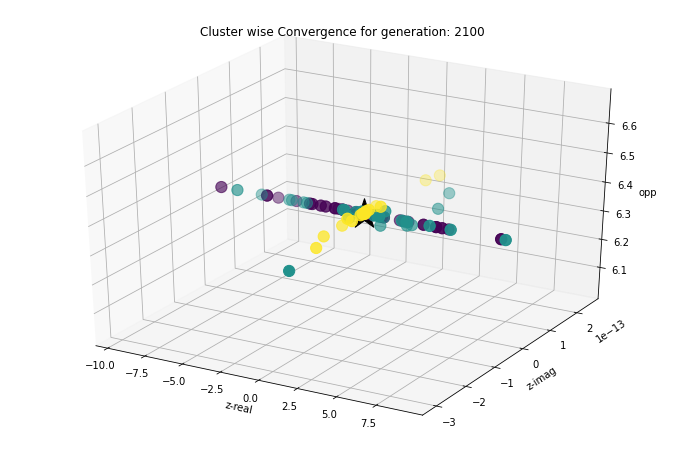

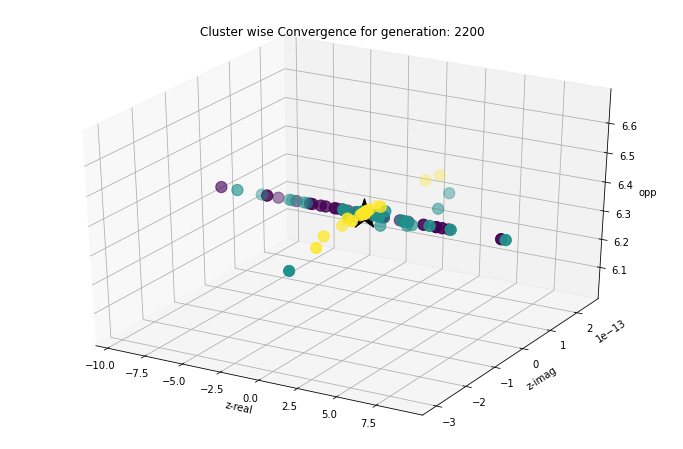

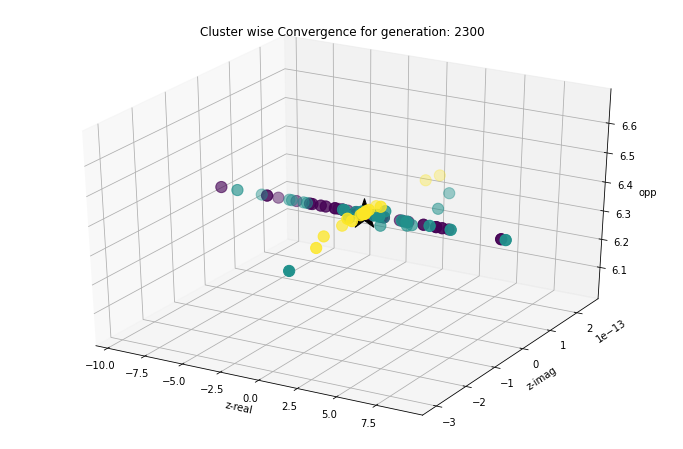

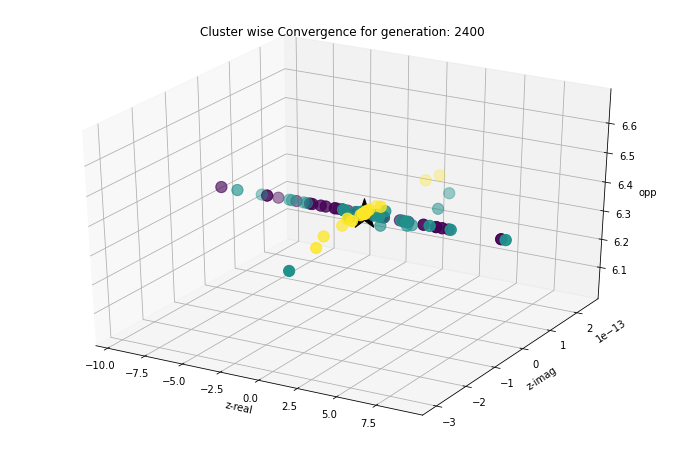

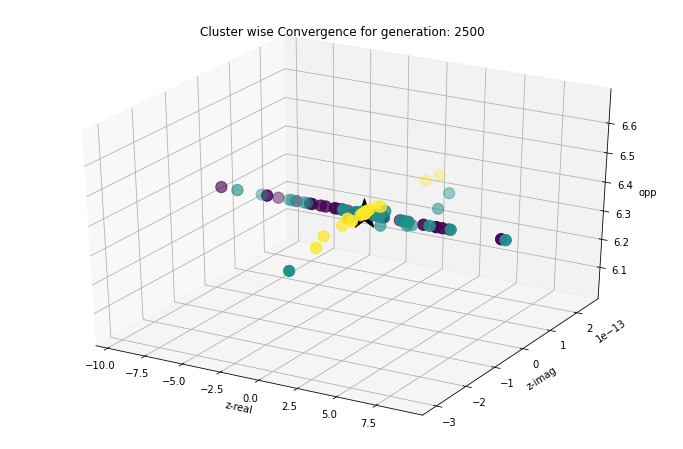

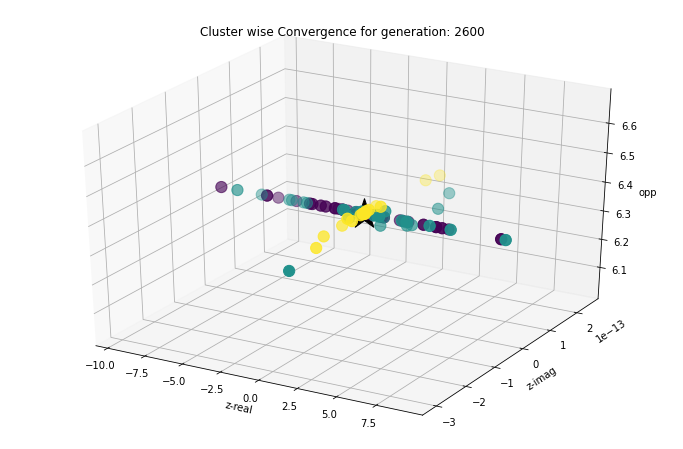

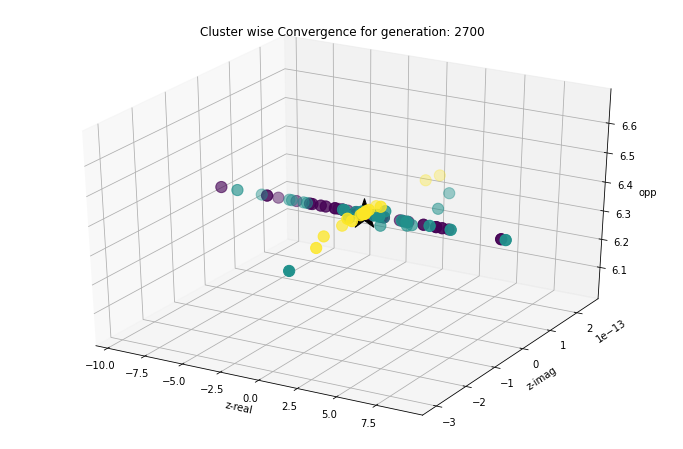

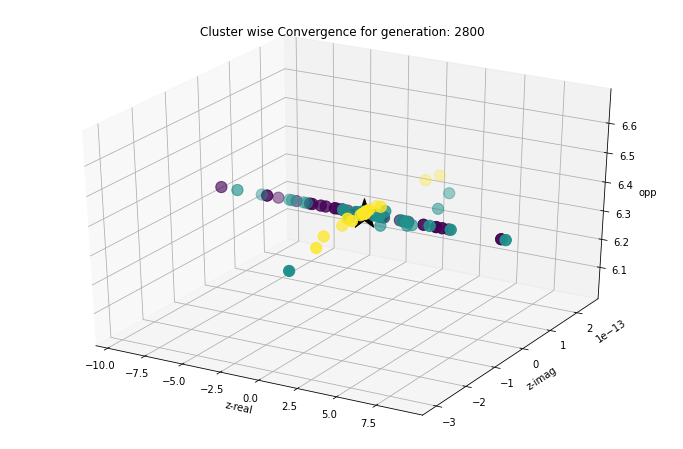

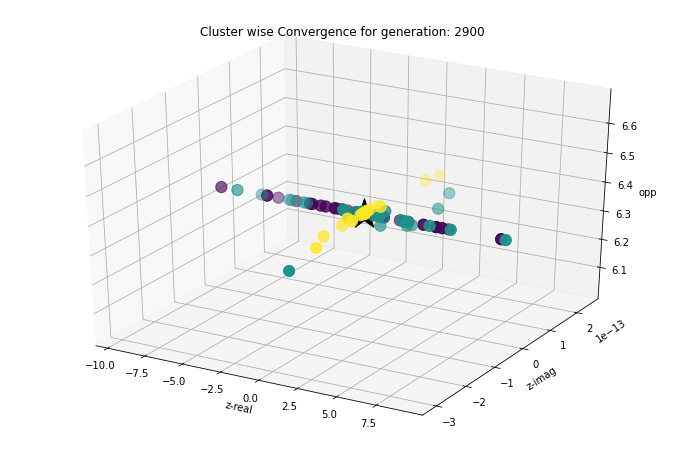

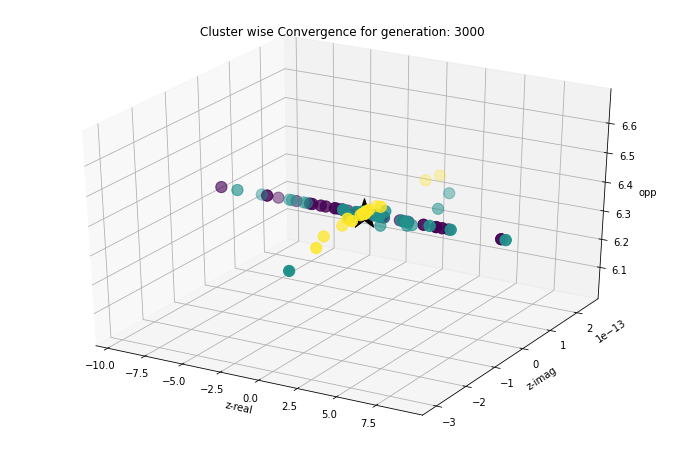

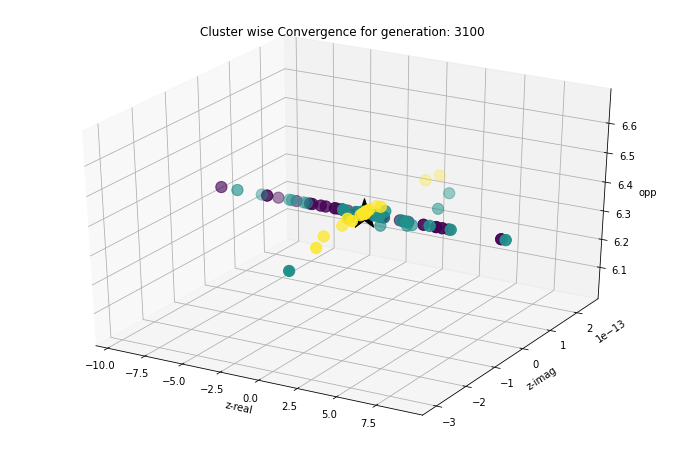

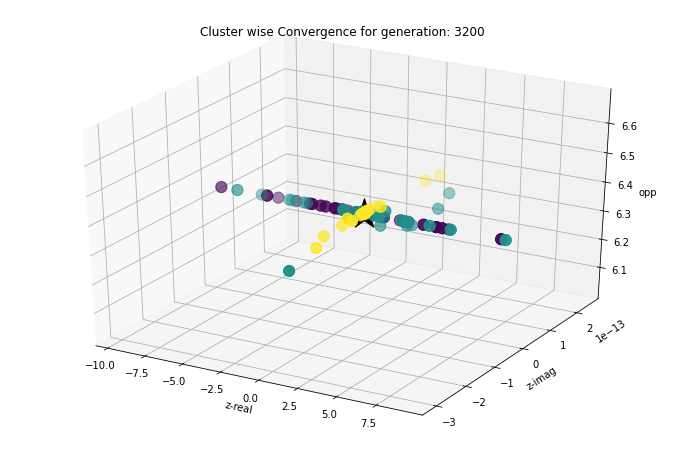

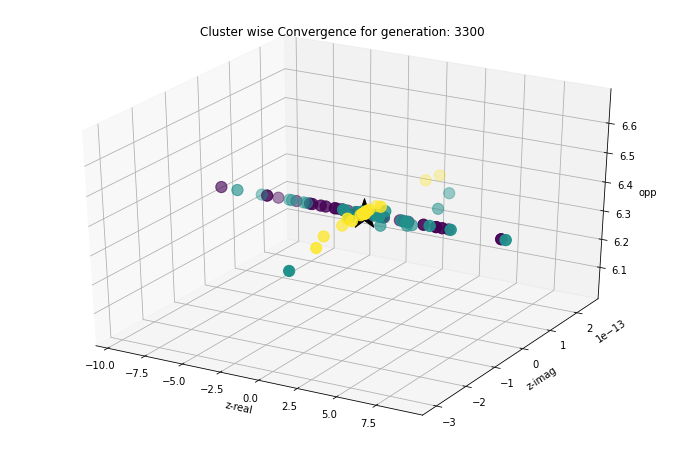

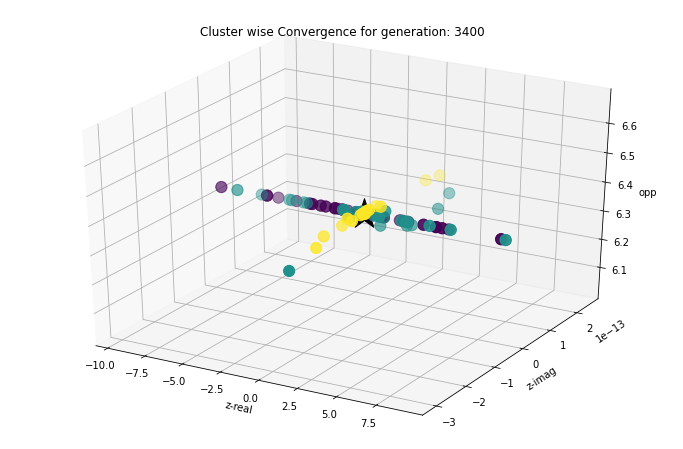

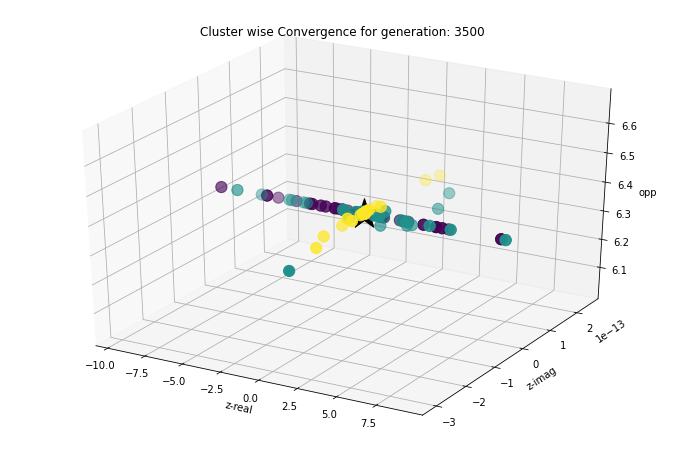

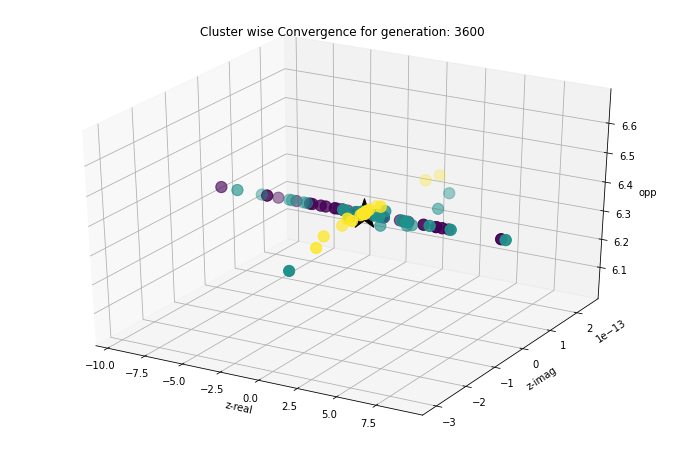

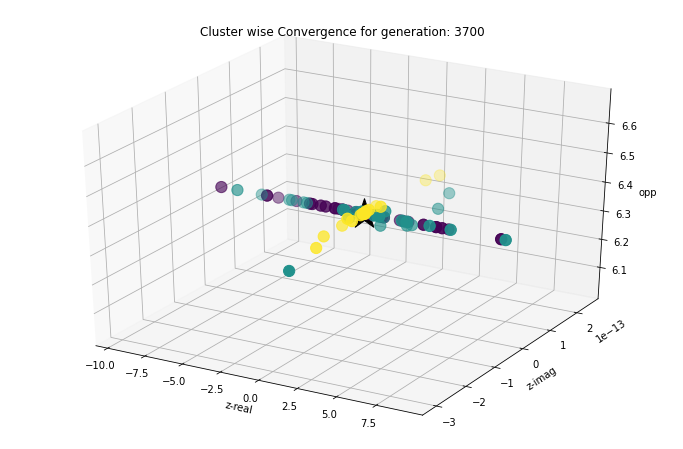

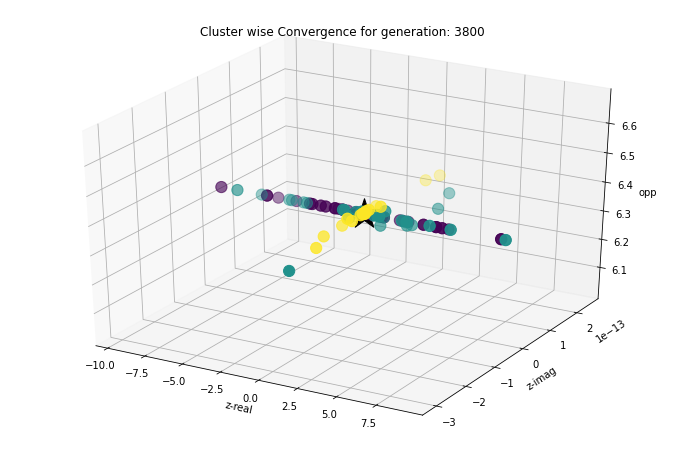

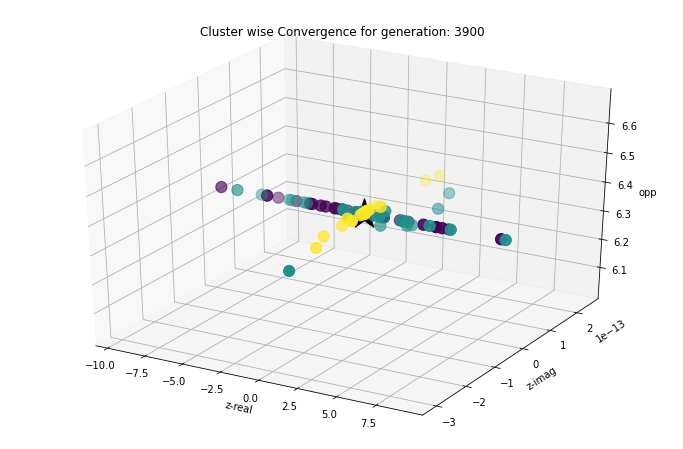

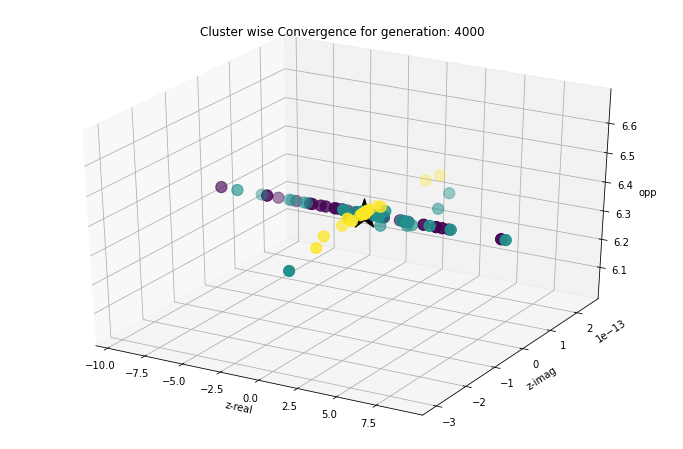

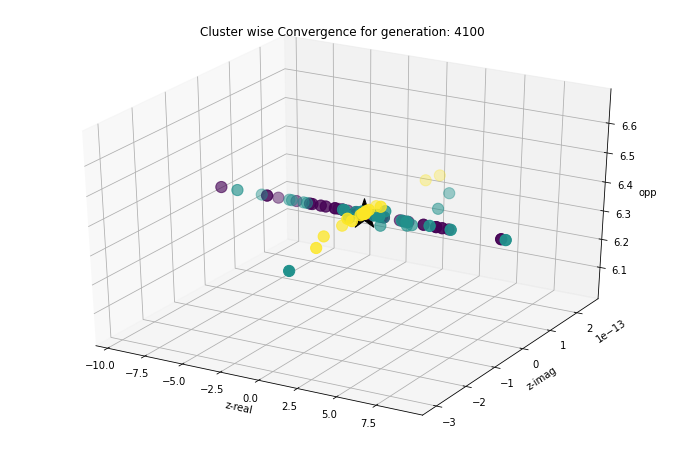

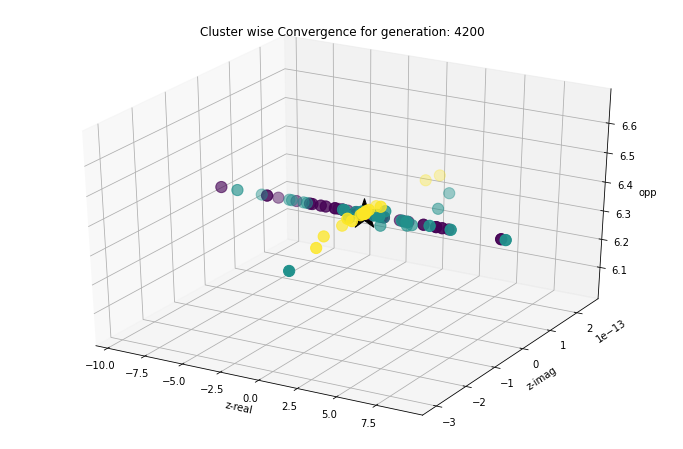

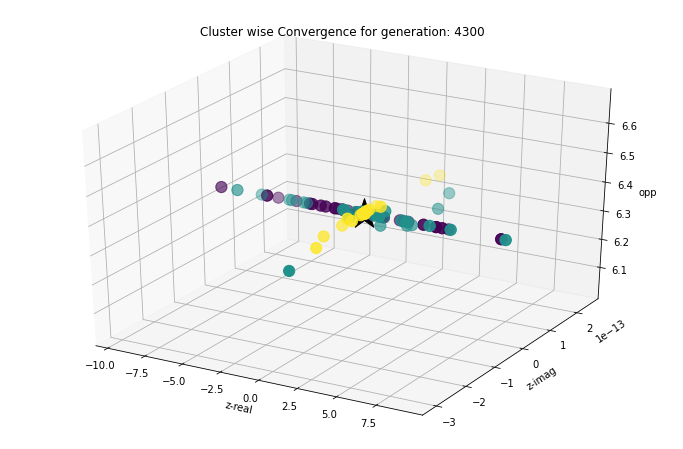

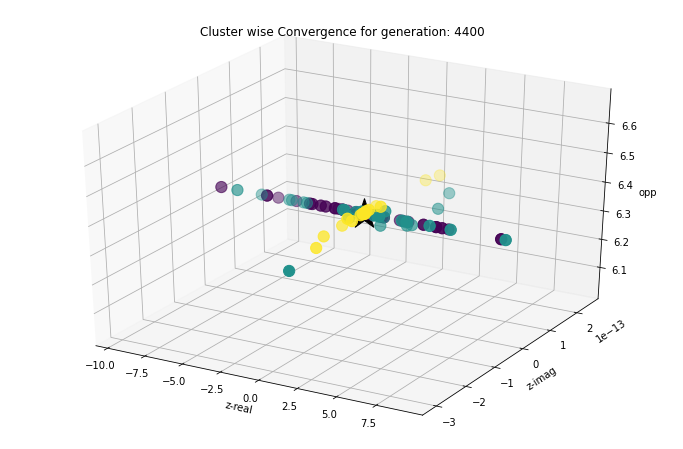

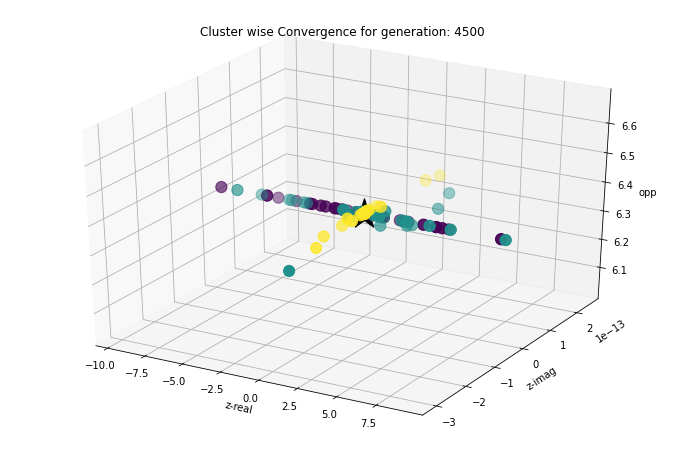

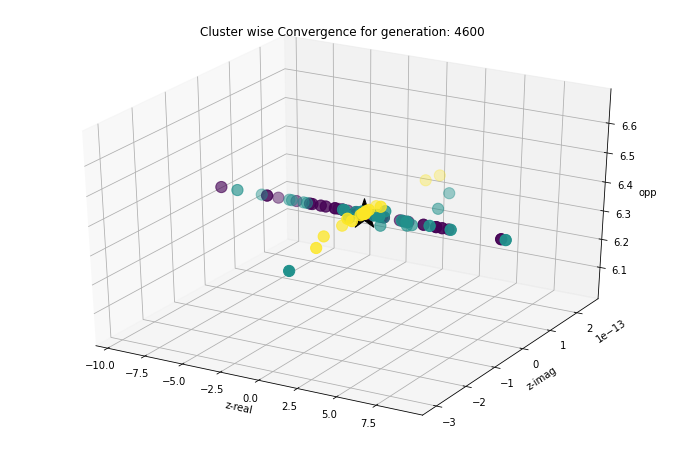

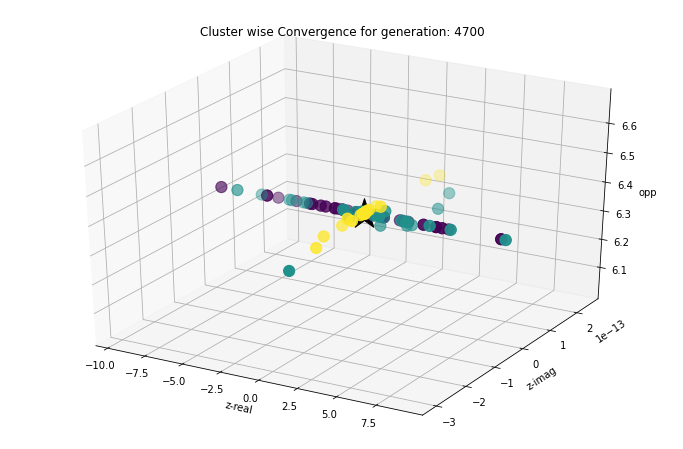

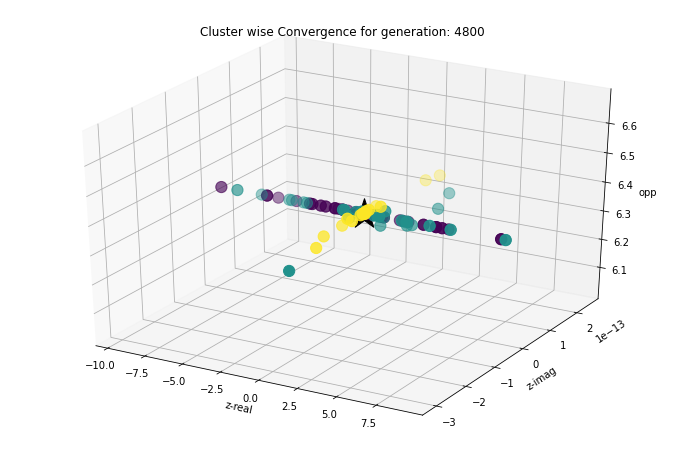

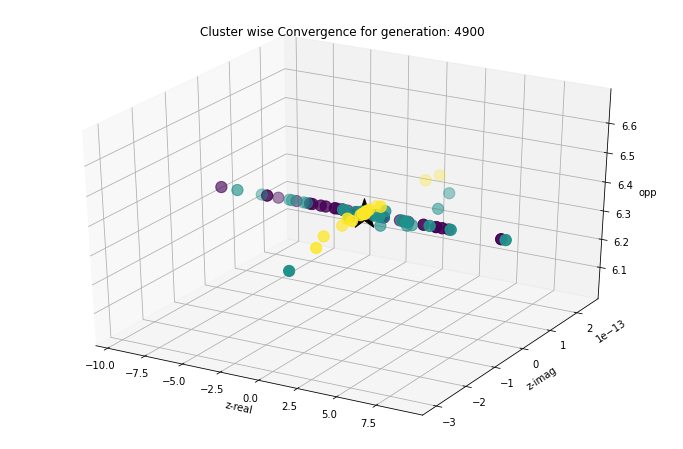

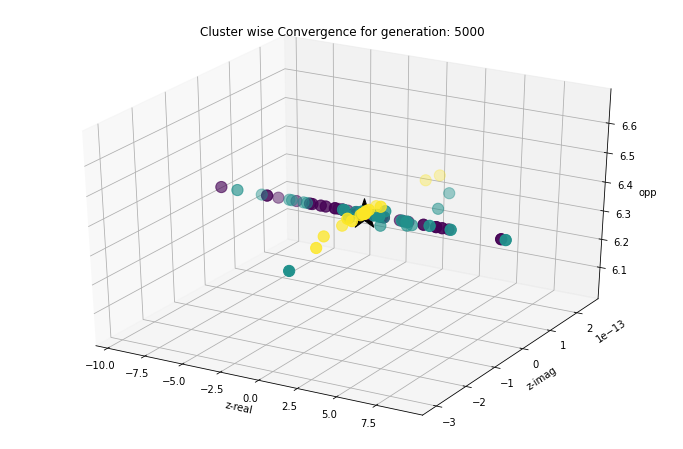

In [167]:
for gen in sol_df.gen.unique():
    if gen%100 == 0:
        df_temp = sol_df[sol_df.gen == gen]
        df_temp.reset_index(inplace=True)
        minimum = np.min(df_temp.opp)
        ind=df_temp[df_temp.opp == minimum].index 
        real,imag,opp,cl=[],[],[],[]
        for col in z_col:
            for x in df_temp[col]:
                real.append(x.real)
                imag.append(x.imag)
        for i in range(len(df_temp)):
            for j in range(len(z_col)):
                opp.append(df_temp['opp'][i])
                cl.append(df_temp['cluster'][i])
        #color = [dic[i] for i in cl.tolist()]
        #print(cl)
        fig = plt.figure(figsize=(12,8))
        ax_1 = fig.gca(projection='3d')
        ax_1.scatter3D(real,imag,opp, s=500,marker='.',c=cl)
        ax_1.scatter3D(df_temp[col][ind[-1]].real,df_temp[col][ind[-1]].imag,minimum, s=1000,marker='*',c='black',zorder=2)
        ax_1.set_xlabel('z-real')
        ax_1.set_ylabel('z-imag')
        ax_1.set_zlabel('opp')
        plt.title('Cluster wise Convergence for generation: '+str(gen))

In [ ]:
for gen in sol_df.gen.unique():
    if gen%100 == 0:
        df_temp = sol_df[sol_df.gen == gen]
        df_temp.reset_index(inplace=True)
        real,imag,opp,cl=[],[],[],[]
        for col in z_col:
            for x in df_temp[col]:
                real.append(x.real)
                imag.append(x.imag)
        for i in range(len(df_temp)):
            for j in range(len(z_col)):
                opp.append(df_temp['opp'][i])
                cl.append(df_temp['cluster'][i])
        #color = [dic[i] for i in cl.tolist()]
        #print(cl)
        fig = plt.figure(figsize=(12,8))
        ax_1 = fig.gca(projection='3d')
        ax_1.scatter3D(real,imag,opp, s=1000,marker='.',c=cl)
        ax_1.set_xlabel('z-real')
        ax_1.set_ylabel('z-imag')
        ax_1.set_zlabel('opp')
        plt.title('Cluster wise Convergence for generation: '+str(gen))

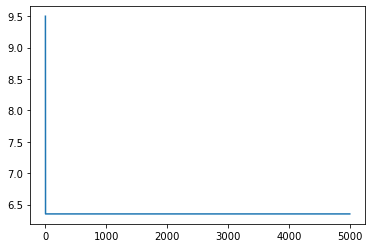

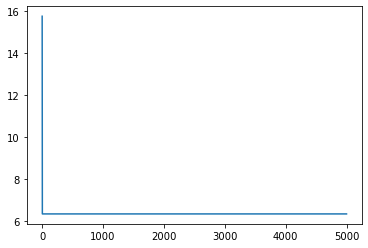

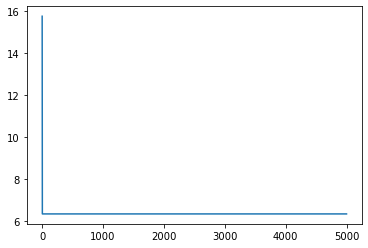

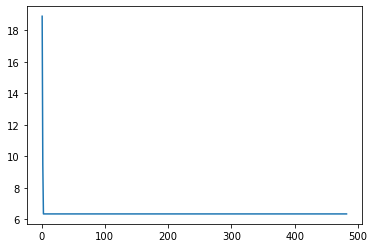

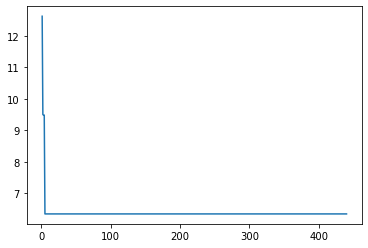

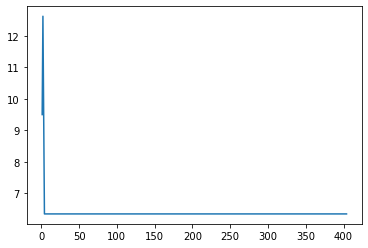

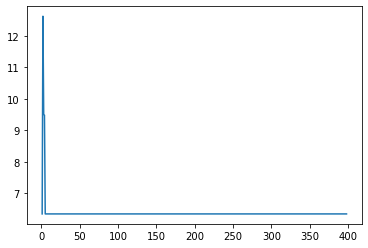

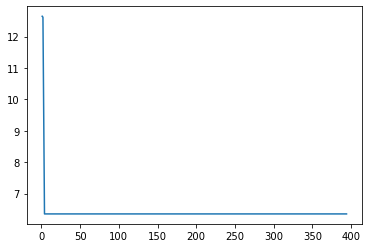

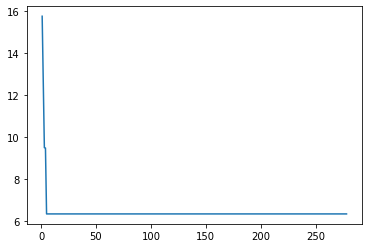

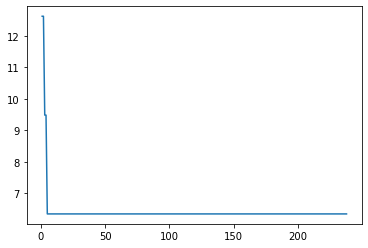

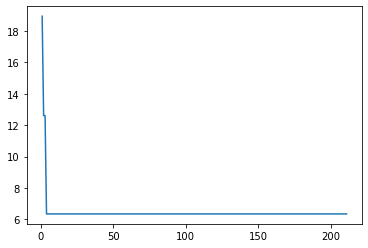

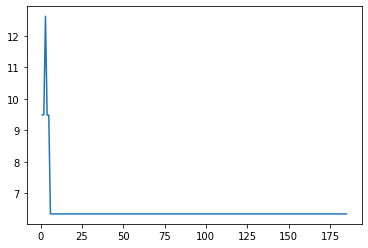

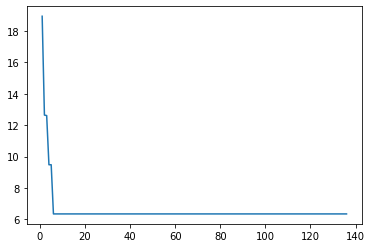

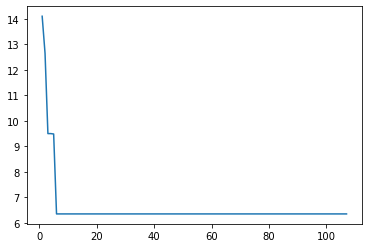

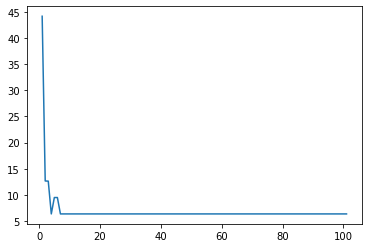

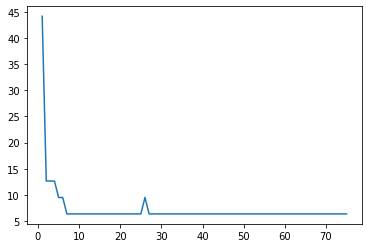

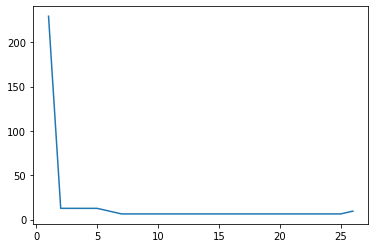

In [133]:
for cl in sol_df.cluster.unique():
    df_temp = sol_df[sol_df.cluster == cl]
    df_temp.reset_index(inplace=True)
    plt.plot(df_temp.gen,df_temp.opp)
    plt.show()

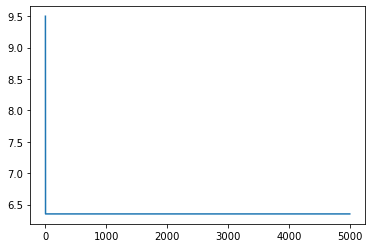

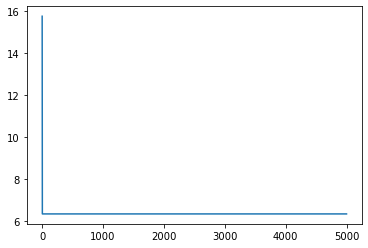

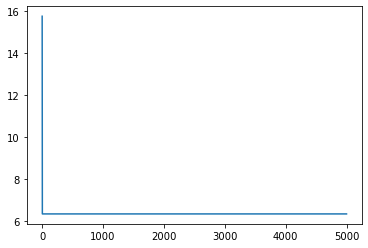

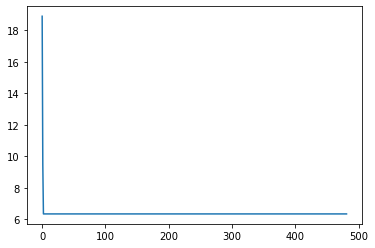

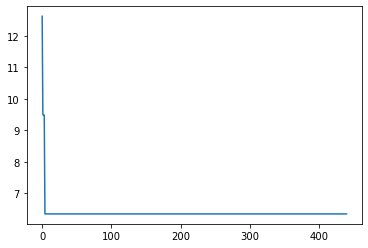

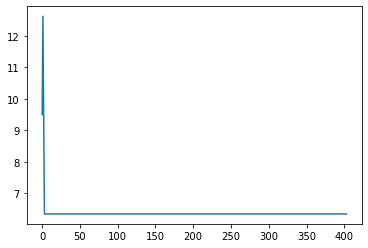

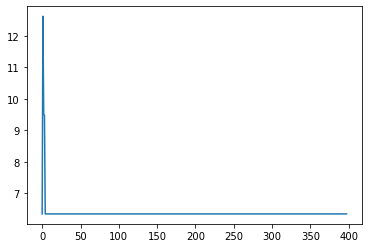

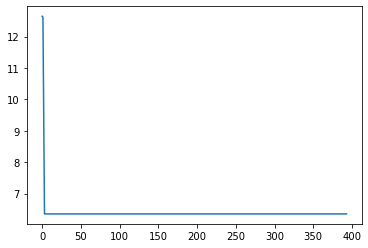

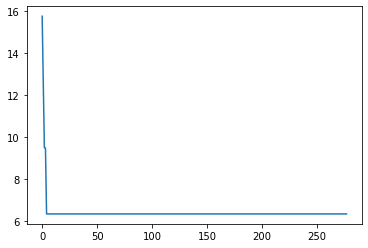

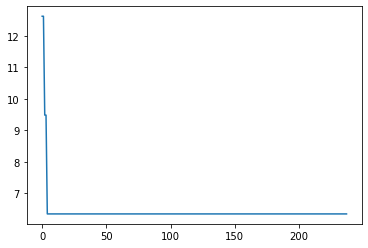

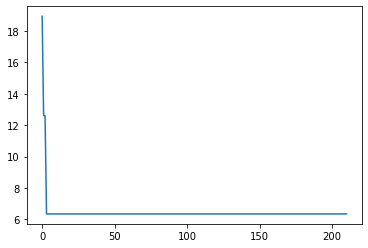

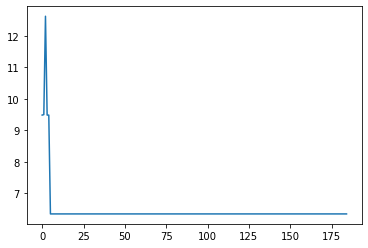

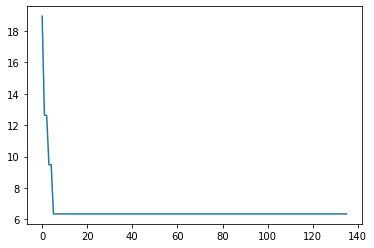

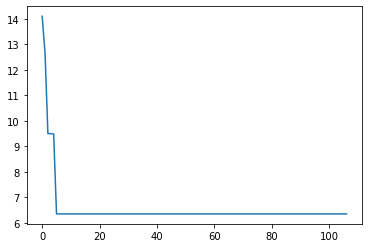

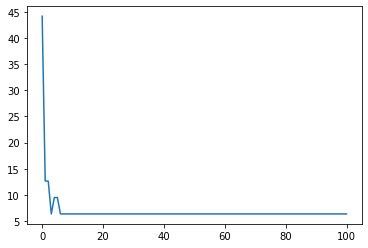

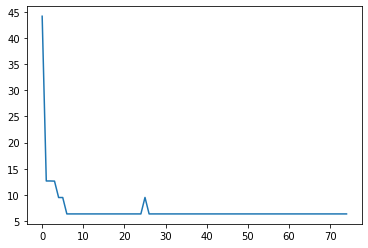

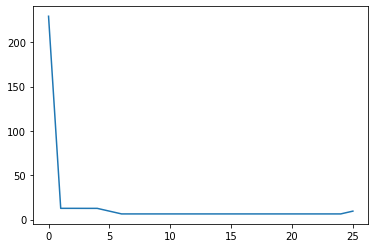

In [136]:
for cl in sol_df.cluster.unique():
    df_temp = sol_df[sol_df.cluster == cl]
    df_temp.reset_index(inplace=True)
    plt.plot(df_temp.opp)
    plt.show()

Text(0.5, 0, 'cluster class')

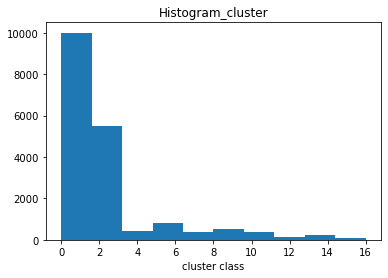

In [169]:
plt.hist(sol_df.cluster)
plt.title('Histogram_cluster')
plt.xlabel('cluster class')

# Plotting contour plots for different generation's cluster solutions

In [ ]:
def Rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

def rastrigin(x):
    A = 10
    n=2
    m=0
    for i in range(n):
        m = m + x[i]**2 + A*np.cos(2*math.pi*x[i])
    
    return 10*n+m
#--------Rastrigin func---------
X = np.linspace(-1, 1, 200)    
Y = np.linspace(-1, 1, 200)    
X, Y = np.meshgrid(X, Y)
Z = Rastrigin(X, Y, A=10)

#--------rastrigin output for cluster points and solution points--------

d = {0:'blue', 1:'green', 2:'red', 3:'yellow'}
sol_df['color'] = sol_df.cluster
sol_df['color']=sol_df.color.map(d)


In [ ]:
for gen in range(50):
    if gen%5 == 0:
        gen_sol = sol_df[sol_df.gen == gen]
        sol_output = [rastrigin([i,j]) for (i,j) in zip(gen_sol.x,gen_sol.y)]
        fig = plt.figure(figsize=(12,8))
        plt.contour(X,Y,Z)
        plt.scatter(gen_sol.x, gen_sol.y,s=100, c=gen_sol.color, marker='+')

# Success Rate 

In [ ]:
number_of_runs = 10
val = 0
success = 0
error = 0.00001
    
for i in range(number_of_runs):
    de = Cluster_DE(num_iterations=100, dim=2, CR=0.4, F=0.48, population_size=60, print_status=False,M=20, func='rastrigin')
    df,sol=de.simulate()
    if sol < error:
        success = success+1
    
print('success rate:',100*success/number_of_runs)

# Animation

In [ ]:
from matplotlib import animation
def Rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

def rastrigin(x):
    A = 10
    n=2
    m=0
    for i in range(n):
        m = m + x[i]**2 + A*np.cos(2*math.pi*x[i])
    
    return 10*n+m
#--------Rastrigin func---------
X = np.linspace(-4, 4, 200)    
Y = np.linspace(-4, 4, 200)    
X, Y = np.meshgrid(X, Y)
Z = Rastrigin(X, Y, A=10)

#--------rastrigin output for cluster points and solution points--------

d = {0:'blue', 1:'green', 2:'red', 3:'yellow'}
sol_df['color'] = sol_df.cluster
sol_df['color']=sol_df.color.map(d)

def animate(i):
    for gen in range(50):
        gen_sol = sol_df[sol_df.gen == gen]
        sol_output = [rastrigin([i,j]) for (i,j) in zip(gen_sol.x,gen_sol.y)]
        #fig = plt.figure(figsize=(12,8))
        plt.contour(X,Y,Z)
        plt.scatter(gen_sol.x, gen_sol.y,s=100, c=gen_sol.color, marker='+')


Writer = animation.writers['pillow']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
ani = animation.FuncAnimation(fig, animate)
ani.save('Contour_plot_cluster.mp4')


In [ ]:
print(animation.writers.list())